In [1]:
%%capture
!git clone https://github.com/AndreasHammerKU/CardiacCTAnalysis.git
%cd CardiacCTAnalysis

Imports from Github Repository

In [2]:
%%capture
!pip install dash
!pip install pycpd
import numpy as np

# Custom Imports
import utils.logger as logs
from bin.Environment import MedicalImageEnvironment
from bin.DataLoader import DataLoader
from bin.Trainer import Trainer
from utils.parser import Experiment, ExperimentConfig

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

dataset_folder = '/content/drive/MyDrive/_2025_aortic_valves'
logs_folder = '/content/drive/MyDrive/logs'
model_folder = '/content/drive/MyDrive/logs/models'

Hyperparameters

In [3]:
debug = False
logger = logs.setup_logger(debug)

dataLoader = DataLoader(dataset_folder, logger=logger, model_dir=model_folder, seed=1, include_pathological=True)

# External Entries with missing data
dataLoader.test_external.remove('HOM_M53_H183_W86_YA')
dataLoader.test_external.remove('HOM_M56_H179_W75_YA')
dataLoader.test_external.remove('HOM_M59_H184_W97_YA')
dataLoader.test_external.remove('HOM_M62_H178_W88_YA')
dataLoader.test_external.remove('HOM_M70_H183_W108_YA')

In [4]:
def run_training(config, logger, dataLoader):
  logger.create_dataframes()
  train_env = MedicalImageEnvironment(logger=logger,
                                dataLoader=dataLoader,
                                image_list=dataLoader.train,
                                agents=config.agents,
                                n_sample_points=config.n_sample_points,
                                add_noise=config.add_noise
                                )
  eval_env = MedicalImageEnvironment(logger=logger,
                                task="eval",
                                dataLoader=dataLoader,
                                image_list=dataLoader.val,
                                n_sample_points=config.n_sample_points,
                                agents=config.agents,
                                train_images=dataLoader.train,
                                add_noise=config.add_noise)
  agent = Trainer(train_environment=train_env,
                   eval_environment=eval_env,
                   task="train",
                   logger=logger,
                   dataLoader=dataLoader,
                   action_dim=train_env.n_actions,
                   attention=config.attention,
                   model_type=config.model_type,
                   rl_framework=config.rl_framework,
                   agents=config.agents,
                   max_steps=config.max_steps,
                   episodes=config.episodes,
                   decay=config.decay,
                   image_interval=config.image_interval,
                   evaluation_steps=config.evaluation_steps,
                   evaluation_interval=config.evaluation_interval,
                   experiment=config.experiment,
                   tau=config.tau)

  agent.train()
  logger.save_to_hdf5(config_obj=config, directory=logs_folder)
  train_env.visualize_current_state()
  eval_env.visualize_current_state()

def run_test(config, logger, dataLoader, external=False):
  logger.create_dataframes()
  test_env = MedicalImageEnvironment(logger=logger,
                                task="test",
                                dataLoader=dataLoader,
                                image_list=dataLoader.test_external if external else dataLoader.test[1:],
                                n_sample_points=config.n_sample_points,
                                agents=config.agents,
                                train_images=dataLoader.train,
                                add_noise=config.add_noise)
  agent = Trainer(test_environment=test_env,
                   task="test",
                   logger=logger,
                   dataLoader=dataLoader,
                   action_dim=test_env.n_actions,
                   attention=config.attention,
                   agents=config.agents,
                   model_name=f"{config.rl_framework}-{config.model_type}-{config.experiment.name}",
                   model_type=config.model_type,
                   rl_framework=config.rl_framework,
                   max_steps=config.max_steps,
                   episodes=config.episodes,
                   evaluation_steps=config.evaluation_steps,
                   evaluation_interval=config.evaluation_interval,
                   experiment=config.experiment
                   )

  agent.test()
  logger.save_to_hdf5(config_obj=config, directory=logs_folder)
  test_env.visualize_current_state()

Experiment 1: Network 3D - work alone

In [5]:
config = ExperimentConfig(model_type="Network3D",
                          rl_framework="DQN",
                          max_steps=500,
                          image_interval=2,
                          episodes=200,
                          agents=6,
                          evaluation_steps=15,
                          evaluation_interval=10,
                          decay=150, # EPSILON = MIN_EPS - (MAX_EPS - MIN_EPS) * e^(-1 * current_step / decay)
                          attention=False,
                          experiment=Experiment.WORK_ALONE,
                          n_sample_points=5,
                          add_noise=True
                          )

INFO:Logger:Episode 1: Total Reward = -0.12 | Final Avg Distance 26.71 | Average error in mm [2.24 2.87 3.49 3.86 4.28 3.57] | Worst Error in mm [3.78 4.85 5.88 6.51 7.22 6.02] Avg Closest Point = 25.92 | Avg Furthest Point = 28.09
INFO:Logger:Episode 2: Total Reward = -0.12 | Final Avg Distance 26.72 | Average error in mm [2.41 3.24 3.86 4.06 5.01 2.82] | Worst Error in mm [4.07 5.47 6.52 6.86 8.46 4.77] Avg Closest Point = 25.73 | Avg Furthest Point = 28.22
INFO:Logger:Episode 3: Total Reward = -0.98 | Final Avg Distance 31.13 | Average error in mm [3.35 3.34 5.9  6.07 5.64 5.36] | Worst Error in mm [ 5.65  5.63  9.95 10.25  9.52  9.05] Avg Closest Point = 29.51 | Avg Furthest Point = 31.83
INFO:Logger:Episode 4: Total Reward = -0.62 | Final Avg Distance 30.76 | Average error in mm [3.98 3.51 5.26 5.82 4.58 5.9 ] | Worst Error in mm [6.72 5.93 8.88 9.82 7.72 9.95] Avg Closest Point = 29.25 | Avg Furthest Point = 31.69
INFO:Logger:Episode 5: Total Reward = -0.15 | Final Avg Distance 2

average error across all agents is 3.069667339324951 mm


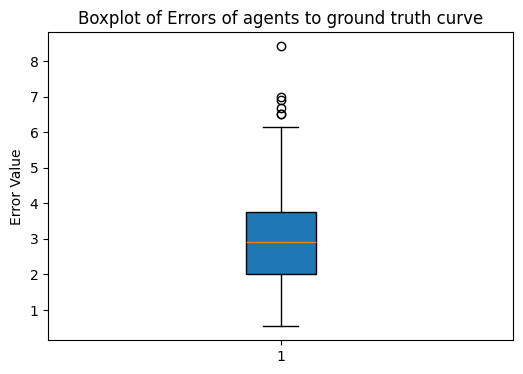

average error across all agents is 4.651485919952393 mm


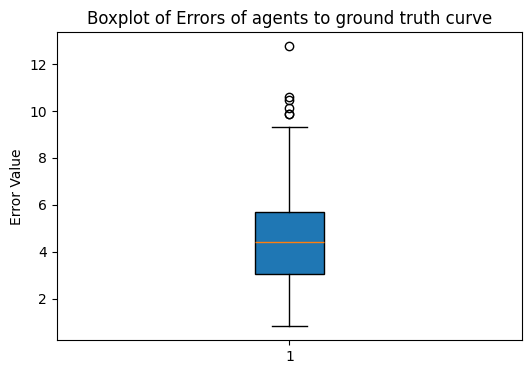

INFO:Logger:Average Validation Reward: -5.39
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -5.39


/content/CardiacCTAnalysis/utils/logger.py:89: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["train_epochs"] = self.train_df
/content/CardiacCTAnalysis/utils/logger.py:90: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


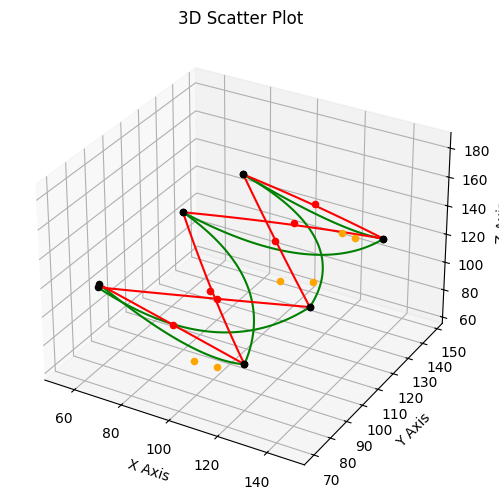

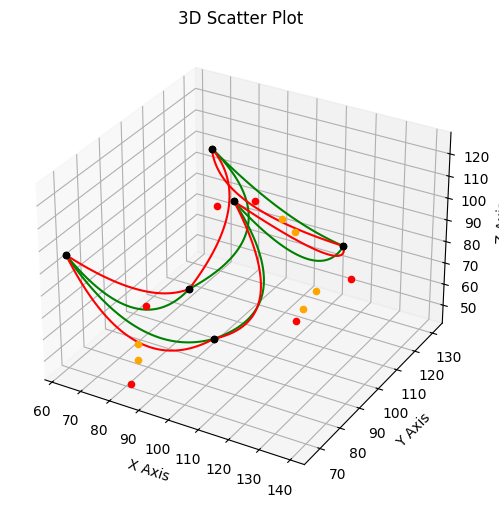

In [6]:
run_training(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = -0.68 | Final Avg Distance 12.92 | Average error in mm [2.32 1.76 0.53 2.5  5.15 1.33] | Worst Error in mm [3.51 2.67 0.81 3.78 7.81 2.01] Avg Closest Point = 9.69 | Avg Furthest Point = 15.80
INFO:Logger:Evaluation Episode 2: Total Reward = 2.46 | Final Avg Distance 11.51 | Average error in mm [1.71 2.45 1.42 1.62 0.61 2.55] | Worst Error in mm [2.6  3.72 2.15 2.46 0.93 3.86] Avg Closest Point = 10.52 | Avg Furthest Point = 13.95
INFO:Logger:Evaluation Episode 3: Total Reward = 0.52 | Final Avg Distance 14.05 | Average error in mm [0.56 1.55 2.67 2.95 7.05 1.99] | Worst Error in mm [ 0.86  2.36  4.04  4.47 10.68  3.02] Avg Closest Point = 11.25 | Avg Furthest Point = 17.13
INFO:Logger:Evaluation Episode 4: Total Reward = -1.96 | Final Avg Distance 9.73 | Average error in mm [1.72 3.29 3.19 0.66 1.03 0.9 ] | Worst Error in mm [2.61 4.98 4.84 1.   1.57 1.36] Avg Closest Point = 6.11 | Avg Furthest Point = 10.78
INFO:Logger:Evaluation Epis

average error across all agents is 2.467052459716797 mm


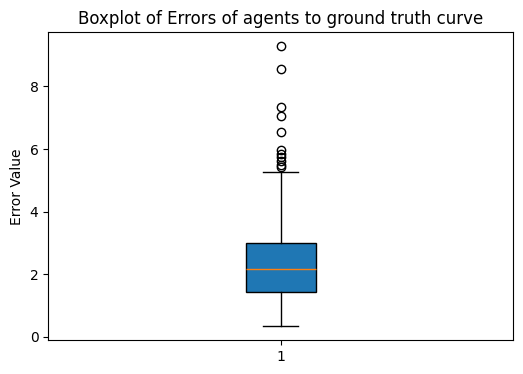

average error across all agents is 3.73833966255188 mm


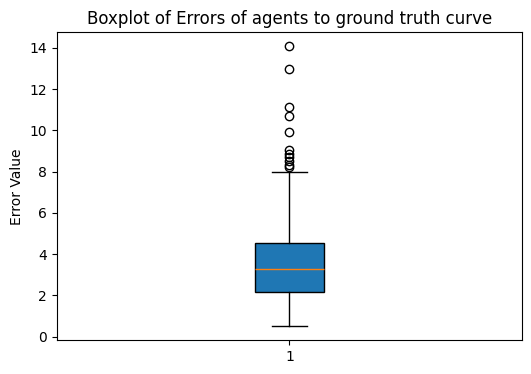

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


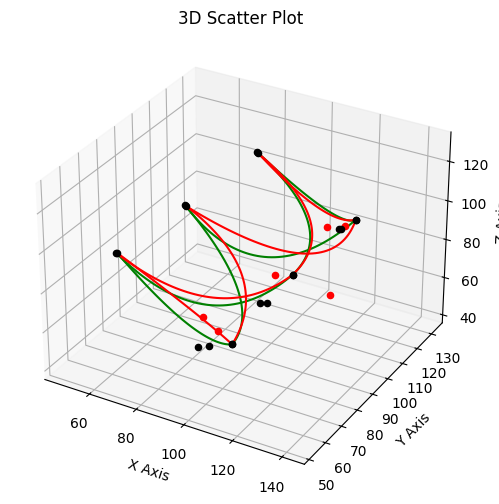

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = -1.59 | Final Avg Distance 17.75 | Average error in mm [2.57 1.09 6.48 0.49 1.75 6.99] | Worst Error in mm [ 3.9   1.66  9.82  0.74  2.66 10.59] Avg Closest Point = 12.97 | Avg Furthest Point = 20.66
INFO:Logger:Evaluation Episode 2: Total Reward = 0.05 | Final Avg Distance 15.77 | Average error in mm [5.04 4.67 0.85 1.28 1.99 2.52] | Worst Error in mm [7.63 7.08 1.29 1.93 3.02 3.81] Avg Closest Point = 15.04 | Avg Furthest Point = 16.73
INFO:Logger:Evaluation Episode 3: Total Reward = -3.47 | Final Avg Distance 15.46 | Average error in mm [5.84 5.6  2.9  4.05 2.31 1.75] | Worst Error in mm [8.85 8.49 4.4  6.13 3.49 2.65] Avg Closest Point = 10.99 | Avg Furthest Point = 16.18
INFO:Logger:Evaluation Episode 4: Total Reward = 1.02 | Final Avg Distance 20.82 | Average error in mm [3.44 1.26 4.12 2.88 4.56 5.56] | Worst Error in mm [5.22 1.91 6.24 4.37 6.91 8.42] Avg Closest Point = 17.85 | Avg Furthest Point = 23.74
INFO:Logger:Evaluation E

average error across all agents is 2.986968755722046 mm


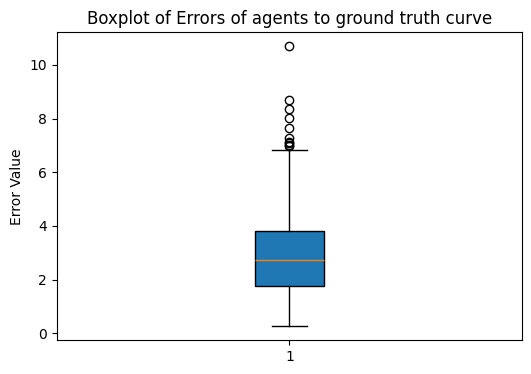

average error across all agents is 4.526171684265137 mm


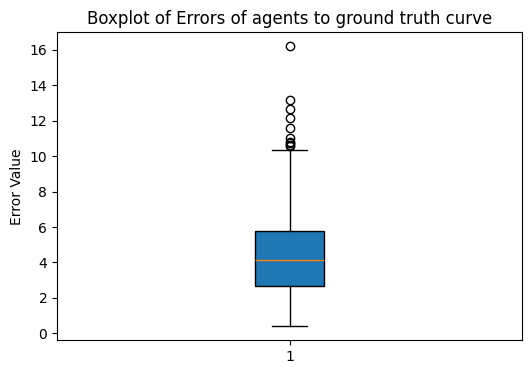

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


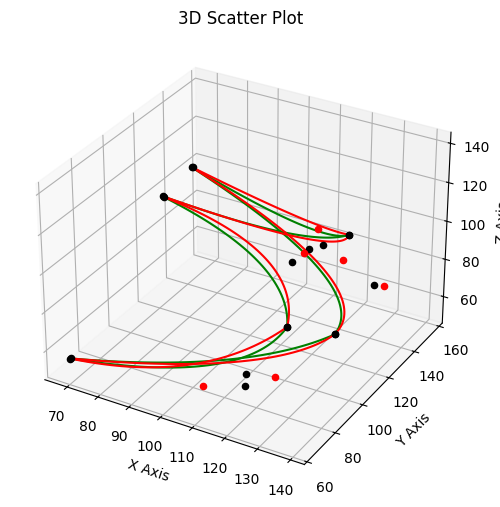

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

Experiment 2: Network 3D - share positions

In [14]:
config.experiment = Experiment.SHARE_POSITIONS

INFO:Logger:Episode 1: Total Reward = -20.53 | Final Avg Distance 44.75 | Average error in mm [12.16  0.88  6.    3.05  2.8  18.96] | Worst Error in mm [20.52  1.48 10.13  5.14  4.72 31.99] Avg Closest Point = 7.25 | Avg Furthest Point = 54.79 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 2: Total Reward = -9.58 | Final Avg Distance 33.80 | Average error in mm [ 2.14  3.07  7.96  1.38 13.8   6.1 ] | Worst Error in mm [ 3.61  5.18 13.43  2.33 23.28 10.29] Avg Closest Point = 7.81 | Avg Furthest Point = 57.01 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 3: Total Reward = -19.77 | Final Avg Distance 41.61 | Average error in mm [ 5.25  9.09 15.12 10.52 21.45 15.31] | Worst Error in mm [ 8.86 15.35 25.52 17.76 36.2  25.84] Avg Closest Point = 6.72 | Avg Furthest Point = 46.90 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 

average error across all agents is 2.356842517852783 mm


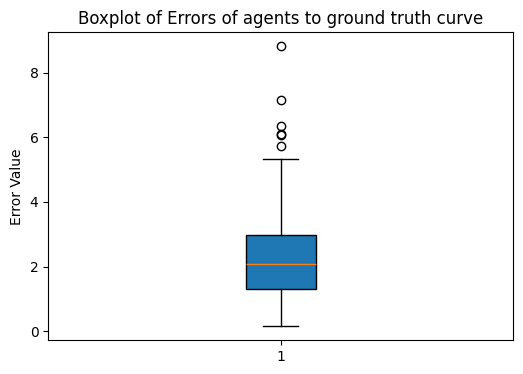

average error across all agents is 3.571338176727295 mm


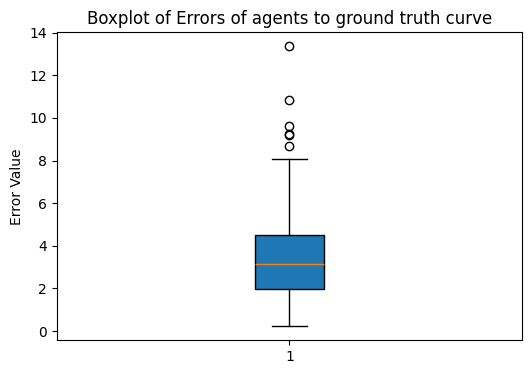

INFO:Logger:Average Validation Reward: -1.19
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -1.19


INFO:Logger:Episode 11: Total Reward = 18.77 | Final Avg Distance 4.29 | Average error in mm [0.78 0.56 0.31 0.69 0.82 0.84] | Worst Error in mm [1.31 0.95 0.52 1.16 1.38 1.42] Avg Closest Point = 1.14 | Avg Furthest Point = 28.02 | Finished Agents = tensor([0, 1, 1, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 12: Total Reward = 19.28 | Final Avg Distance 3.78 | Average error in mm [0.6  0.52 0.78 0.65 0.48 0.31] | Worst Error in mm [1.01 0.88 1.31 1.1  0.82 0.52] Avg Closest Point = 1.41 | Avg Furthest Point = 28.37 | Finished Agents = tensor([0, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 13: Total Reward = 11.44 | Final Avg Distance 9.53 | Average error in mm [1.54 3.82 1.38 0.96 1.79 3.7 ] | Worst Error in mm [2.6  6.45 2.32 1.62 3.02 6.24] Avg Closest Point = 3.89 | Avg Furthest Point = 30.86 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 14: Total Reward = 16.30 | Final Avg D

average error across all agents is 2.377248525619507 mm


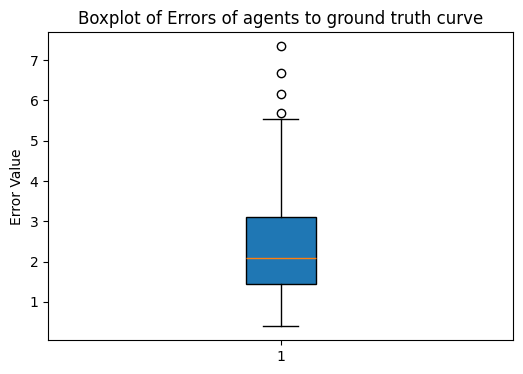

average error across all agents is 3.602259397506714 mm


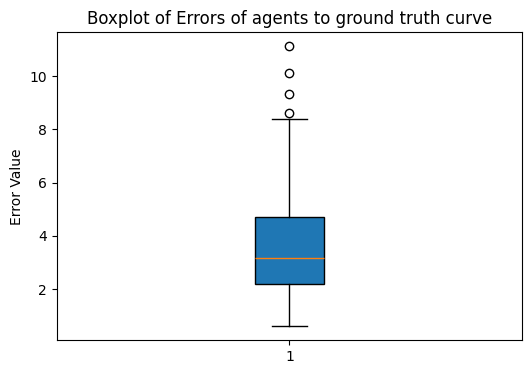

INFO:Logger:Average Validation Reward: -1.32


Average Total Reward: -1.32


INFO:Logger:Episode 21: Total Reward = 20.39 | Final Avg Distance 4.28 | Average error in mm [0.73 1.01 0.42 0.51 0.88 0.66] | Worst Error in mm [1.23 1.71 0.71 0.85 1.48 1.11] Avg Closest Point = 1.41 | Avg Furthest Point = 27.19 | Finished Agents = tensor([0, 0, 1, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 22: Total Reward = 20.49 | Final Avg Distance 4.17 | Average error in mm [0.52 0.8  0.66 0.78 0.46 0.68] | Worst Error in mm [0.88 1.34 1.11 1.31 0.77 1.14] Avg Closest Point = 1.37 | Avg Furthest Point = 26.70 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 23: Total Reward = 11.80 | Final Avg Distance 15.51 | Average error in mm [1.85 1.53 3.29 2.21 1.91 2.18] | Worst Error in mm [3.12 2.57 5.55 3.72 3.22 3.67] Avg Closest Point = 4.64 | Avg Furthest Point = 42.43 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 24: Total Reward = 21.02 | Final Avg 

average error across all agents is 2.3660941123962402 mm


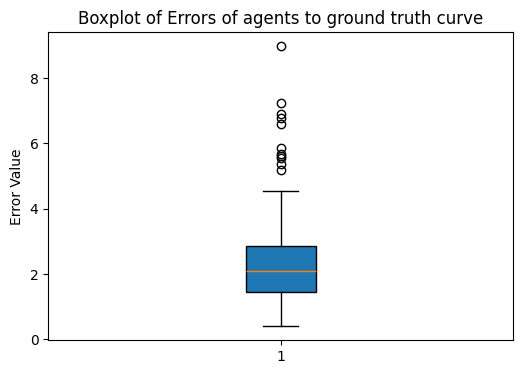

average error across all agents is 3.5853569507598877 mm


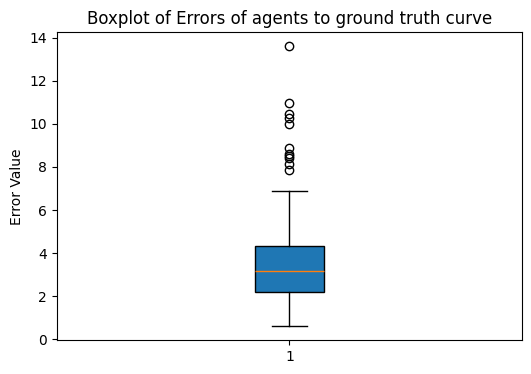

INFO:Logger:Average Validation Reward: -1.22


Average Total Reward: -1.22


INFO:Logger:Episode 31: Total Reward = 16.69 | Final Avg Distance 8.89 | Average error in mm [2.73 0.59 0.95 1.52 0.76 1.19] | Worst Error in mm [4.6  1.   1.6  2.56 1.28 2.  ] Avg Closest Point = 1.14 | Avg Furthest Point = 26.27 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 32: Total Reward = 14.47 | Final Avg Distance 11.12 | Average error in mm [1.28 0.59 1.19 5.08 1.23 0.69] | Worst Error in mm [2.16 1.   2.   8.57 2.08 1.16] Avg Closest Point = 0.67 | Avg Furthest Point = 30.06 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 33: Total Reward = 10.10 | Final Avg Distance 21.36 | Average error in mm [ 2.95  1.03 10.91  5.09  2.21  1.73] | Worst Error in mm [ 4.98  1.74 18.41  8.59  3.72  2.91] Avg Closest Point = 3.51 | Avg Furthest Point = 49.08 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 34: Total Reward = 11.95

average error across all agents is 2.3911142349243164 mm


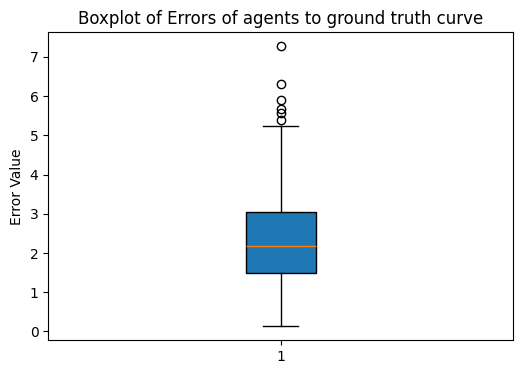

average error across all agents is 3.623270034790039 mm


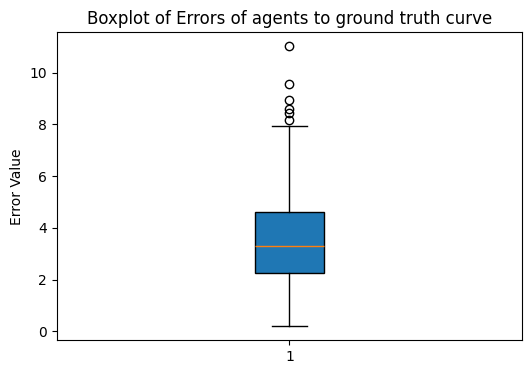

INFO:Logger:Average Validation Reward: -1.48


Average Total Reward: -1.48


INFO:Logger:Episode 41: Total Reward = 22.79 | Final Avg Distance 4.39 | Average error in mm [0.81 1.29 0.23 0.59 0.94 0.58] | Worst Error in mm [1.37 2.17 0.4  0.99 1.58 0.98] Avg Closest Point = 1.83 | Avg Furthest Point = 30.30 | Finished Agents = tensor([0, 0, 1, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 42: Total Reward = 22.95 | Final Avg Distance 4.23 | Average error in mm [0.81 0.58 0.93 0.58 0.94 0.58] | Worst Error in mm [1.37 0.98 1.57 0.98 1.58 0.98] Avg Closest Point = 0.47 | Avg Furthest Point = 28.17 | Finished Agents = tensor([0, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 43: Total Reward = 19.00 | Final Avg Distance 4.33 | Average error in mm [0.25 0.74 1.1  0.74 0.62 1.48] | Worst Error in mm [0.42 1.25 1.85 1.25 1.04 2.49] Avg Closest Point = 1.70 | Avg Furthest Point = 26.32 | Finished Agents = tensor([1, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 44: Total Reward = 18.62 | Final Avg D

average error across all agents is 2.398106813430786 mm


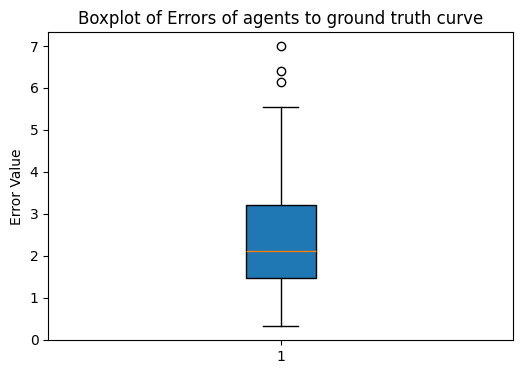

average error across all agents is 3.6338658332824707 mm


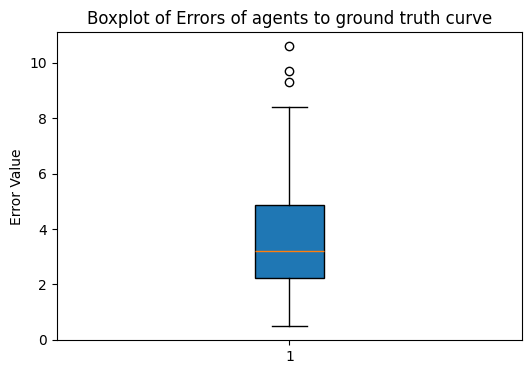

INFO:Logger:Average Validation Reward: -1.52


Average Total Reward: -1.52


INFO:Logger:Episode 51: Total Reward = 17.79 | Final Avg Distance 4.72 | Average error in mm [0.75 1.42 0.9  0.33 0.66 0.56] | Worst Error in mm [1.26 2.4  1.52 0.56 1.12 0.94] Avg Closest Point = 0.74 | Avg Furthest Point = 24.84 | Finished Agents = tensor([0, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 52: Total Reward = 18.27 | Final Avg Distance 4.24 | Average error in mm [0.77 0.54 0.91 0.77 0.64 0.54] | Worst Error in mm [1.3  0.92 1.54 1.3  1.08 0.92] Avg Closest Point = 1.54 | Avg Furthest Point = 23.69 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 53: Total Reward = -24.80 | Final Avg Distance 48.68 | Average error in mm [ 4.63  5.27  9.    5.99 12.5   8.2 ] | Worst Error in mm [ 7.81  8.88 15.18 10.12 21.09 13.84] Avg Closest Point = 2.47 | Avg Furthest Point = 49.68 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 54: Total Reward = 15.94

average error across all agents is 2.244769334793091 mm


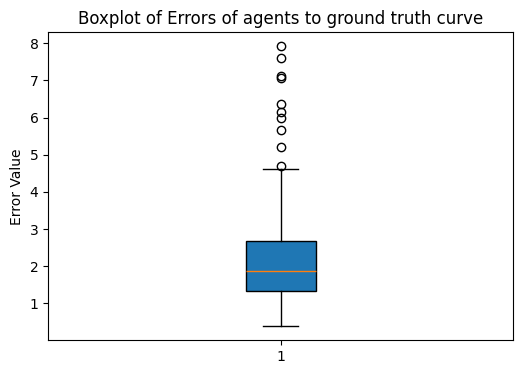

average error across all agents is 3.401512861251831 mm


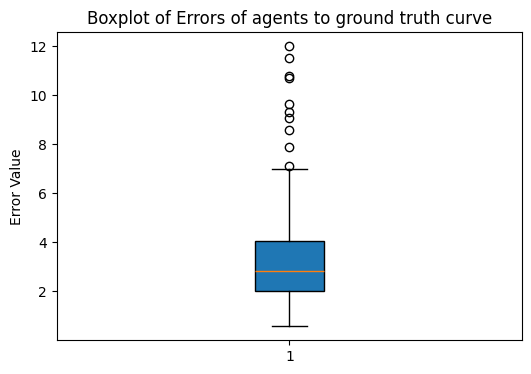

INFO:Logger:Average Validation Reward: -0.71
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -0.71


INFO:Logger:Episode 61: Total Reward = 10.10 | Final Avg Distance 15.83 | Average error in mm [4.53 4.21 1.33 2.97 2.98 0.11] | Worst Error in mm [7.64 7.11 2.25 5.01 5.02 0.18] Avg Closest Point = 4.68 | Avg Furthest Point = 31.36 | Finished Agents = tensor([0, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 62: Total Reward = 21.53 | Final Avg Distance 4.40 | Average error in mm [0.57 0.44 1.35 0.55 0.8  0.58] | Worst Error in mm [0.97 0.75 2.29 0.93 1.35 0.98] Avg Closest Point = 1.12 | Avg Furthest Point = 27.28 | Finished Agents = tensor([0, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 63: Total Reward = 13.93 | Final Avg Distance 13.09 | Average error in mm [2.   0.7  5.22 0.88 0.88 3.96] | Worst Error in mm [3.37 1.18 8.81 1.49 1.48 6.68] Avg Closest Point = 2.75 | Avg Furthest Point = 30.61 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 64: Total Reward = 22.75 | Final Avg

average error across all agents is 2.323749542236328 mm


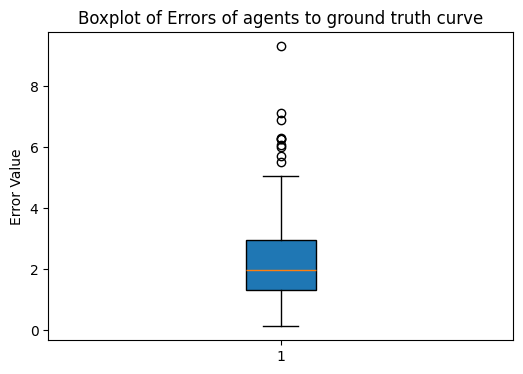

average error across all agents is 3.5211915969848633 mm


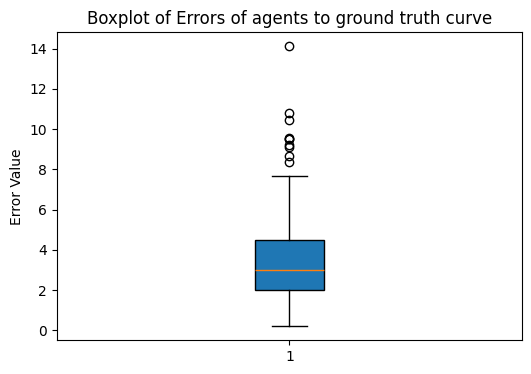

INFO:Logger:Average Validation Reward: -1.02


Average Total Reward: -1.02


INFO:Logger:Episode 71: Total Reward = 24.01 | Final Avg Distance 10.67 | Average error in mm [2.21 1.29 0.51 1.57 3.23 0.87] | Worst Error in mm [3.72 2.17 0.85 2.65 5.45 1.46] Avg Closest Point = 2.54 | Avg Furthest Point = 38.24 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 72: Total Reward = 30.31 | Final Avg Distance 4.37 | Average error in mm [0.57 0.99 0.75 0.12 1.23 0.87] | Worst Error in mm [0.96 1.66 1.26 0.2  2.07 1.46] Avg Closest Point = 1.00 | Avg Furthest Point = 36.57 | Finished Agents = tensor([0, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 73: Total Reward = 22.00 | Final Avg Distance 3.39 | Average error in mm [0.83 0.41 0.56 1.22 0.41 0.56] | Worst Error in mm [1.39 0.7  0.95 2.07 0.7  0.95] Avg Closest Point = 1.49 | Avg Furthest Point = 28.96 | Finished Agents = tensor([0, 1, 1, 0, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 74: Total Reward = 21.45 | Final Avg 

average error across all agents is 2.28973388671875 mm


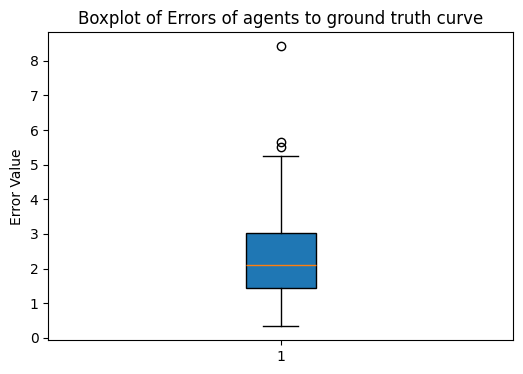

average error across all agents is 3.4696478843688965 mm


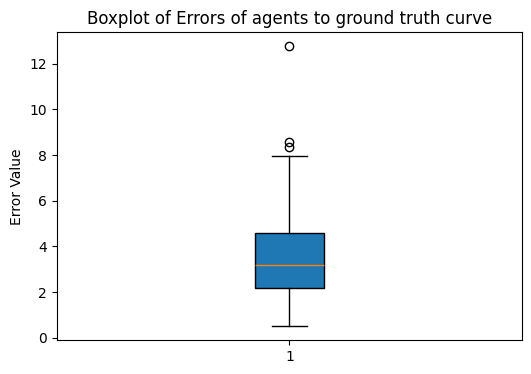

INFO:Logger:Average Validation Reward: -1.16


Average Total Reward: -1.16


INFO:Logger:Episode 81: Total Reward = 8.90 | Final Avg Distance 10.99 | Average error in mm [3.22 1.83 2.3  4.92 1.7  3.19] | Worst Error in mm [5.44 3.09 3.88 8.3  2.86 5.38] Avg Closest Point = 2.10 | Avg Furthest Point = 26.17 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 82: Total Reward = 16.53 | Final Avg Distance 3.36 | Average error in mm [0.74 0.13 0.79 1.07 0.87 0.47] | Worst Error in mm [1.24 0.22 1.34 1.81 1.46 0.8 ] Avg Closest Point = 1.19 | Avg Furthest Point = 20.46 | Finished Agents = tensor([0, 1, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 83: Total Reward = 1.97 | Final Avg Distance 32.31 | Average error in mm [3.68 3.78 9.98 3.76 0.3  5.08] | Worst Error in mm [ 6.2   6.38 16.85  6.35  0.51  8.56] Avg Closest Point = 3.37 | Avg Furthest Point = 45.05 | Finished Agents = tensor([0, 0, 0, 0, 1, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 84: Total Reward = 24.85 | Final

average error across all agents is 2.4256632328033447 mm


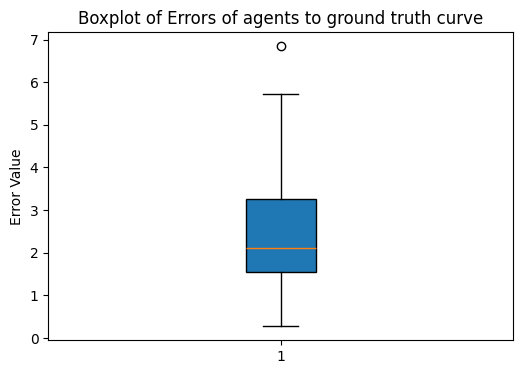

average error across all agents is 3.6756224632263184 mm


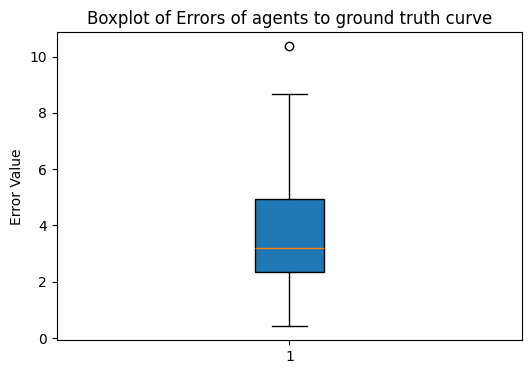

INFO:Logger:Average Validation Reward: -1.74


Average Total Reward: -1.74


INFO:Logger:Episode 91: Total Reward = 16.06 | Final Avg Distance 14.61 | Average error in mm [1.01 2.54 6.56 0.35 1.63 1.72] | Worst Error in mm [ 1.7   4.29 11.08  0.6   2.74  2.89] Avg Closest Point = 5.30 | Avg Furthest Point = 37.38 | Finished Agents = tensor([0, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 92: Total Reward = 27.64 | Final Avg Distance 3.03 | Average error in mm [0.38 0.5  0.41 0.12 0.56 0.77] | Worst Error in mm [0.65 0.85 0.7  0.2  0.95 1.3 ] Avg Closest Point = 0.62 | Avg Furthest Point = 33.12 | Finished Agents = tensor([0, 0, 1, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 93: Total Reward = -18.54 | Final Avg Distance 34.74 | Average error in mm [11.74  7.23  8.29  6.04  8.72  9.07] | Worst Error in mm [19.81 12.2  13.99 10.19 14.72 15.3 ] Avg Closest Point = 3.61 | Avg Furthest Point = 36.26 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 94: Total Reward 

average error across all agents is 2.3833110332489014 mm


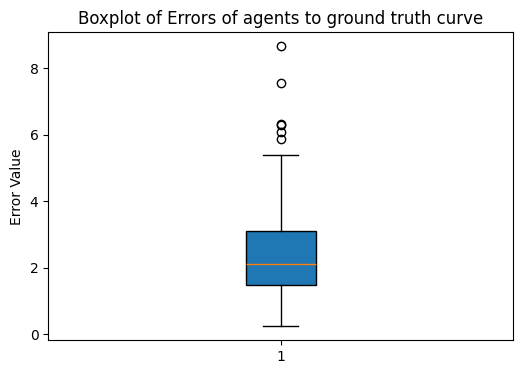

average error across all agents is 3.611445665359497 mm


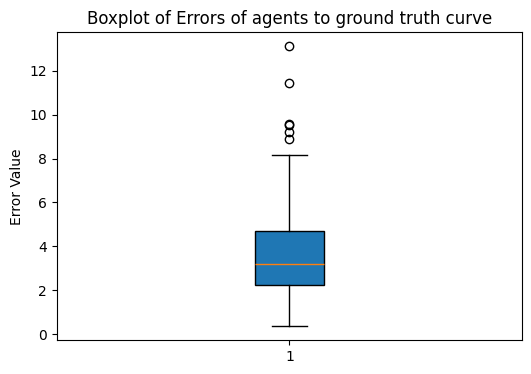

INFO:Logger:Average Validation Reward: -1.02


Average Total Reward: -1.02


/content/CardiacCTAnalysis/utils/logger.py:89: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["train_epochs"] = self.train_df
/content/CardiacCTAnalysis/utils/logger.py:90: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


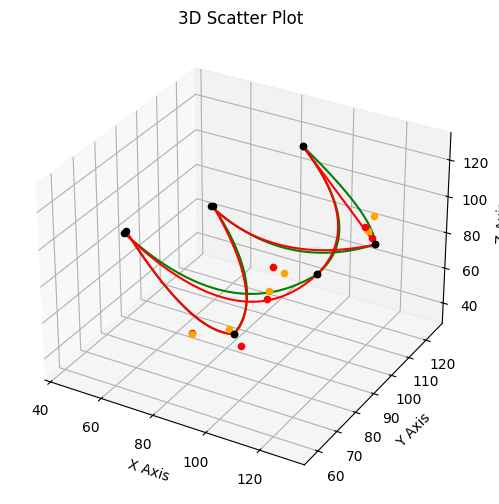

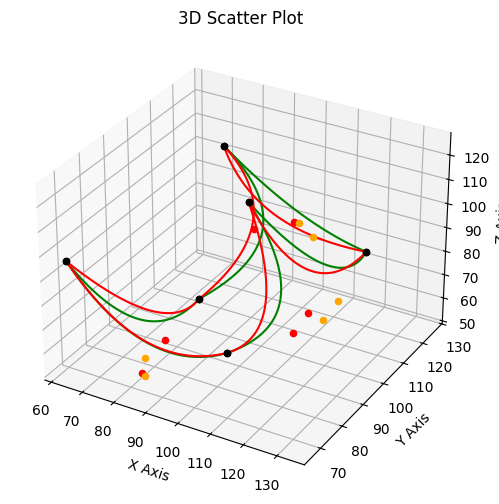

In [15]:
run_training(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = 1.15 | Final Avg Distance 11.09 | Average error in mm [0.96 1.27 1.83 1.46 3.22 3.68] | Worst Error in mm [1.46 1.92 2.78 2.22 4.88 5.58] Avg Closest Point = 9.46 | Avg Furthest Point = 14.08
INFO:Logger:Evaluation Episode 2: Total Reward = -1.48 | Final Avg Distance 15.45 | Average error in mm [0.51 3.05 3.44 1.01 2.63 4.37] | Worst Error in mm [0.78 4.62 5.21 1.53 3.98 6.62] Avg Closest Point = 12.05 | Avg Furthest Point = 17.43
INFO:Logger:Evaluation Episode 3: Total Reward = -3.53 | Final Avg Distance 18.10 | Average error in mm [1.22 5.51 4.14 3.04 3.52 2.98] | Worst Error in mm [1.84 8.35 6.27 4.6  5.33 4.52] Avg Closest Point = 13.57 | Avg Furthest Point = 18.73
INFO:Logger:Evaluation Episode 4: Total Reward = -0.53 | Final Avg Distance 8.30 | Average error in mm [0.46 1.13 1.27 2.89 1.76 1.19] | Worst Error in mm [0.7  1.71 1.92 4.38 2.67 1.81] Avg Closest Point = 6.08 | Avg Furthest Point = 9.87
INFO:Logger:Evaluation Episode 5:

average error across all agents is 2.3439741134643555 mm


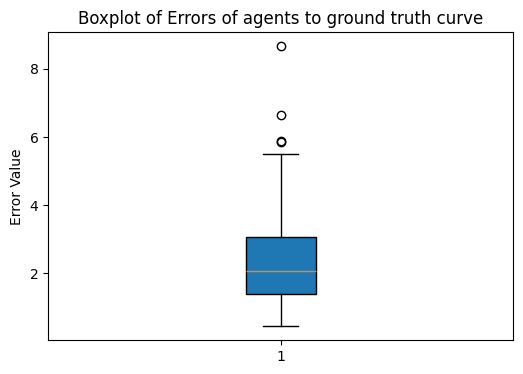

average error across all agents is 3.5518381595611572 mm


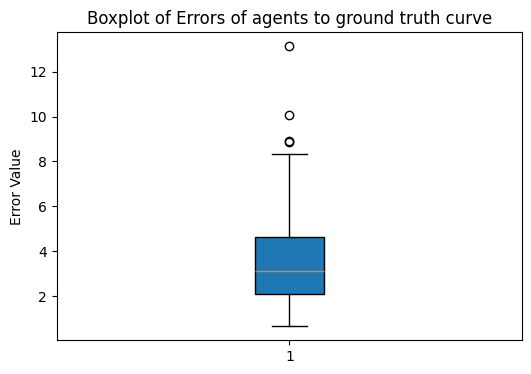

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


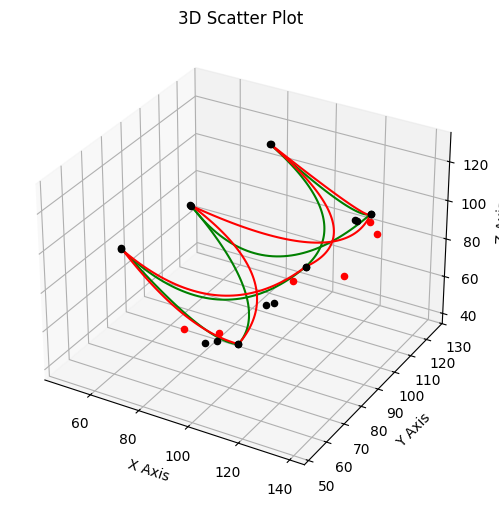

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = 3.19 | Final Avg Distance 12.97 | Average error in mm [1.27 1.58 3.61 2.19 2.48 3.15] | Worst Error in mm [1.92 2.4  5.47 3.32 3.76 4.78] Avg Closest Point = 11.39 | Avg Furthest Point = 16.72
INFO:Logger:Evaluation Episode 2: Total Reward = 1.30 | Final Avg Distance 14.53 | Average error in mm [3.74 2.6  1.35 1.78 1.54 2.06] | Worst Error in mm [5.67 3.94 2.05 2.69 2.33 3.13] Avg Closest Point = 12.51 | Avg Furthest Point = 16.33
INFO:Logger:Evaluation Episode 3: Total Reward = -2.82 | Final Avg Distance 14.81 | Average error in mm [5.44 3.73 3.18 4.52 5.68 0.8 ] | Worst Error in mm [8.24 5.65 4.81 6.85 8.61 1.21] Avg Closest Point = 10.81 | Avg Furthest Point = 15.50
INFO:Logger:Evaluation Episode 4: Total Reward = 1.05 | Final Avg Distance 20.79 | Average error in mm [1.09 1.48 6.81 2.98 3.48 6.53] | Worst Error in mm [ 1.65  2.25 10.32  4.52  5.28  9.9 ] Avg Closest Point = 18.56 | Avg Furthest Point = 23.53
INFO:Logger:Evaluation Ep

average error across all agents is 3.0359690189361572 mm


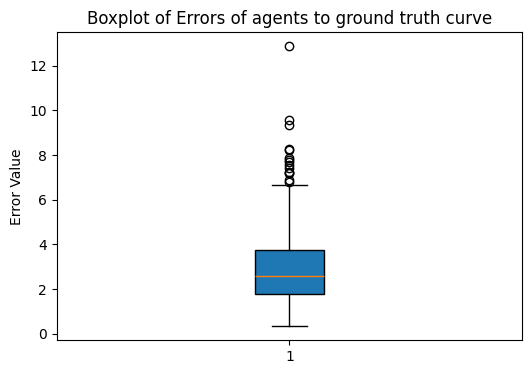

average error across all agents is 4.600422382354736 mm


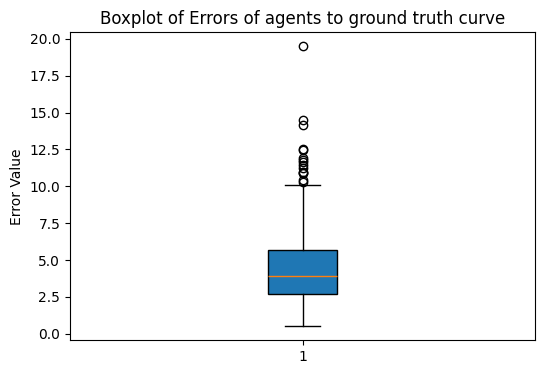

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


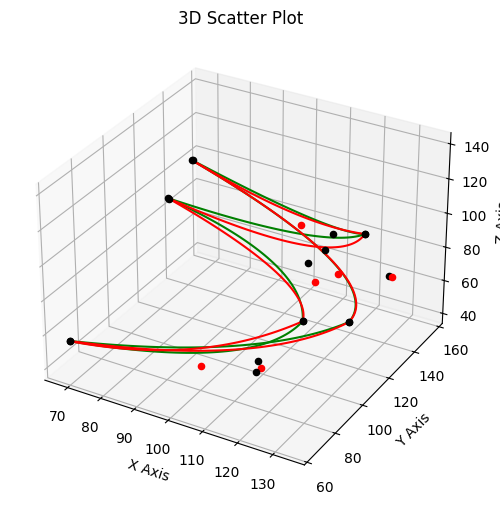

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

Experiment 3: Network 3D share pairwise positions

In [16]:
config.experiment = Experiment.SHARE_PAIRWISE

INFO:Logger:Episode 1: Total Reward = -60.14 | Final Avg Distance 83.66 | Average error in mm [11.09  8.03 11.13 13.1  13.   21.88] | Worst Error in mm [18.72 13.54 18.77 22.11 21.93 36.92] Avg Closest Point = 11.82 | Avg Furthest Point = 83.74 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 2: Total Reward = -69.86 | Final Avg Distance 93.37 | Average error in mm [10.24 25.81 14.91 12.44 22.98  8.4 ] | Worst Error in mm [17.29 43.55 25.15 20.99 38.79 14.18] Avg Closest Point = 17.25 | Avg Furthest Point = 93.57 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 3: Total Reward = -30.44 | Final Avg Distance 58.93 | Average error in mm [15.7   8.51 12.96  7.26  2.86  1.68] | Worst Error in mm [26.5  14.36 21.86 12.26  4.83  2.84] Avg Closest Point = 9.39 | Avg Furthest Point = 79.33 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episo

average error across all agents is 2.398239850997925 mm


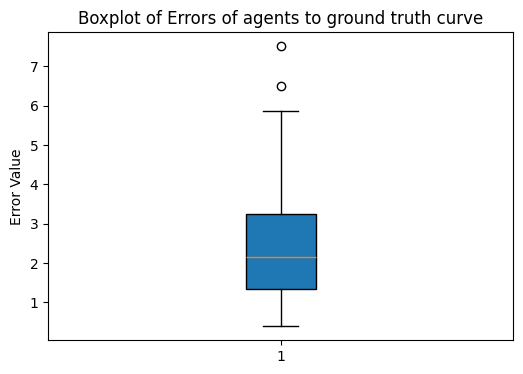

average error across all agents is 3.634068012237549 mm


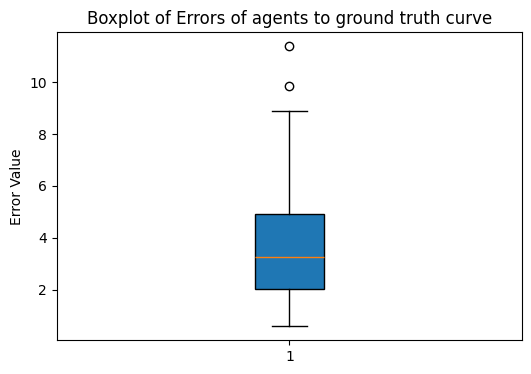

INFO:Logger:Average Validation Reward: -1.39
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -1.39


INFO:Logger:Episode 11: Total Reward = 24.56 | Final Avg Distance 5.55 | Average error in mm [1.01 0.48 0.39 1.58 0.63 0.9 ] | Worst Error in mm [1.71 0.81 0.65 2.67 1.06 1.51] Avg Closest Point = 1.24 | Avg Furthest Point = 31.47 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 12: Total Reward = 25.58 | Final Avg Distance 4.52 | Average error in mm [0.83 1.41 0.63 0.69 0.45 0.63] | Worst Error in mm [1.41 2.37 1.06 1.16 0.76 1.06] Avg Closest Point = 1.56 | Avg Furthest Point = 31.16 | Finished Agents = tensor([0, 0, 0, 0, 1, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 13: Total Reward = -0.80 | Final Avg Distance 30.54 | Average error in mm [4.25 7.94 0.42 1.67 7.21 7.45] | Worst Error in mm [ 7.16 13.41  0.7   2.81 12.16 12.57] Avg Closest Point = 6.21 | Avg Furthest Point = 52.54 | Finished Agents = tensor([0, 0, 1, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 14: Total Reward = 20.76 | Fina

average error across all agents is 2.5888521671295166 mm


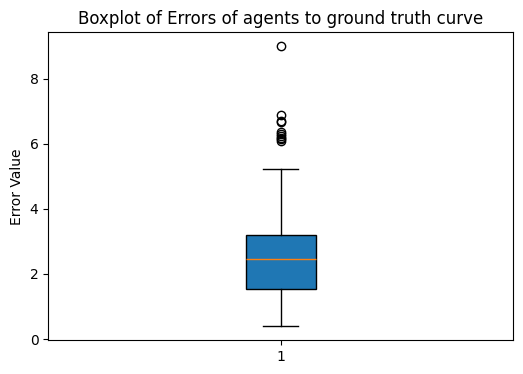

average error across all agents is 3.922903299331665 mm


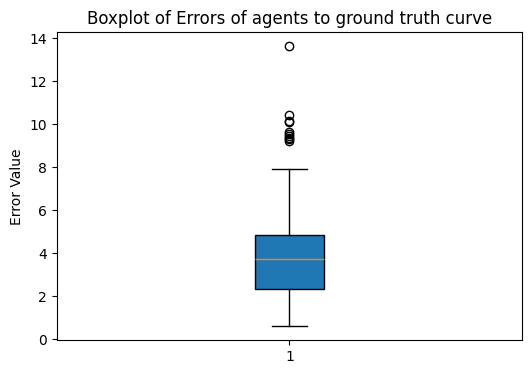

INFO:Logger:Average Validation Reward: -2.68


Average Total Reward: -2.68


INFO:Logger:Episode 21: Total Reward = 26.58 | Final Avg Distance 6.35 | Average error in mm [0.81 0.92 1.19 0.96 1.26 1.28] | Worst Error in mm [1.36 1.56 2.02 1.62 2.12 2.17] Avg Closest Point = 2.25 | Avg Furthest Point = 37.04 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 22: Total Reward = 28.97 | Final Avg Distance 3.96 | Average error in mm [0.78 0.81 0.3  0.42 0.92 0.45] | Worst Error in mm [1.31 1.36 0.5  0.7  1.56 0.76] Avg Closest Point = 1.07 | Avg Furthest Point = 37.32 | Finished Agents = tensor([0, 0, 1, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 23: Total Reward = 12.67 | Final Avg Distance 19.00 | Average error in mm [0.68 8.25 4.9  0.87 1.1  0.95] | Worst Error in mm [ 1.15 13.92  8.28  1.48  1.86  1.6 ] Avg Closest Point = 2.90 | Avg Furthest Point = 39.38 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 24: Total Reward = 26.46 | Fina

average error across all agents is 2.379990816116333 mm


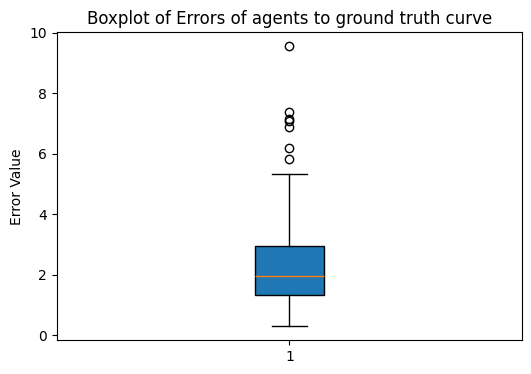

average error across all agents is 3.606414556503296 mm


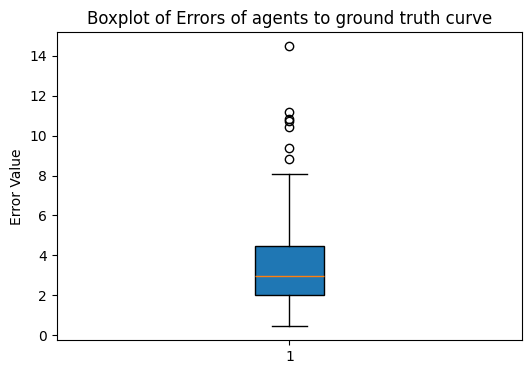

INFO:Logger:Average Validation Reward: -0.93
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -0.93


INFO:Logger:Episode 31: Total Reward = 26.05 | Final Avg Distance 7.98 | Average error in mm [0.6  1.55 2.74 1.56 1.2  0.6 ] | Worst Error in mm [1.01 2.62 4.63 2.63 2.02 1.01] Avg Closest Point = 1.64 | Avg Furthest Point = 35.74 | Finished Agents = tensor([1, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 32: Total Reward = 30.82 | Final Avg Distance 3.22 | Average error in mm [0.36 0.36 1.07 0.12 0.71 0.84] | Worst Error in mm [0.6  0.6  1.81 0.2  1.21 1.41] Avg Closest Point = 1.24 | Avg Furthest Point = 36.66 | Finished Agents = tensor([1, 1, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 33: Total Reward = -6.62 | Final Avg Distance 23.65 | Average error in mm [ 5.22 18.87  8.96  2.97  4.93  2.97] | Worst Error in mm [ 8.81 31.84 15.13  5.01  8.32  5.01] Avg Closest Point = 2.71 | Avg Furthest Point = 36.53 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 34: Total Reward = 15.03 

average error across all agents is 2.176647186279297 mm


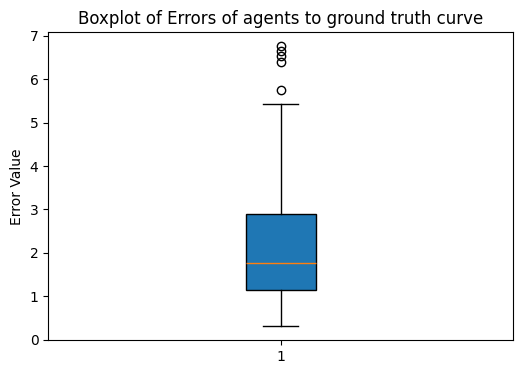

average error across all agents is 3.2982869148254395 mm


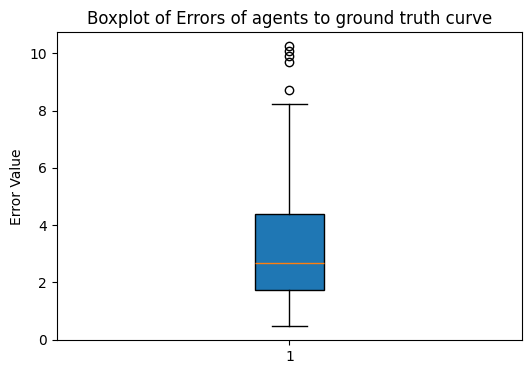

INFO:Logger:Average Validation Reward: -0.37
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -0.37


INFO:Logger:Episode 41: Total Reward = 20.28 | Final Avg Distance 4.22 | Average error in mm [0.63 0.99 0.98 0.63 0.86 0.75] | Worst Error in mm [1.06 1.67 1.66 1.06 1.46 1.26] Avg Closest Point = 2.36 | Avg Furthest Point = 27.26 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 42: Total Reward = 20.84 | Final Avg Distance 3.66 | Average error in mm [0.86 0.76 0.47 0.38 0.37 0.76] | Worst Error in mm [1.46 1.29 0.8  0.64 0.63 1.27] Avg Closest Point = 0.71 | Avg Furthest Point = 25.47 | Finished Agents = tensor([0, 0, 0, 1, 1, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 43: Total Reward = 19.14 | Final Avg Distance 4.42 | Average error in mm [1.36 0.96 0.55 0.35 0.79 0.32] | Worst Error in mm [2.29 1.62 0.93 0.58 1.33 0.54] Avg Closest Point = 1.54 | Avg Furthest Point = 27.02 | Finished Agents = tensor([0, 0, 0, 1, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 44: Total Reward = 19.37 | Final Avg D

average error across all agents is 2.5466277599334717 mm


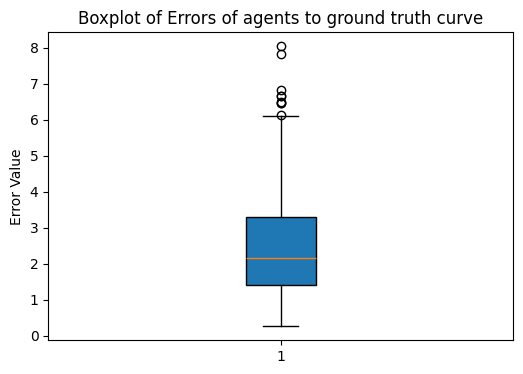

average error across all agents is 3.8589208126068115 mm


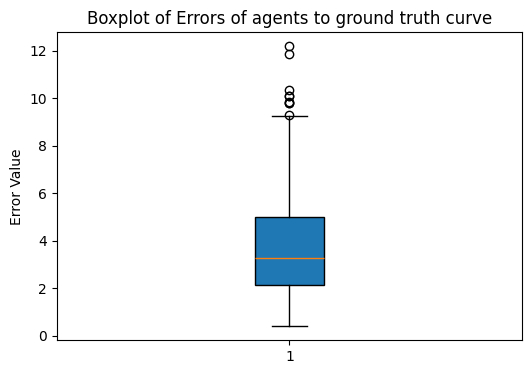

INFO:Logger:Average Validation Reward: -2.02


Average Total Reward: -2.02


INFO:Logger:Episode 51: Total Reward = 3.61 | Final Avg Distance 20.12 | Average error in mm [1.58 1.5  7.67 2.01 4.03 3.58] | Worst Error in mm [ 2.67  2.52 12.94  3.38  6.8   6.05] Avg Closest Point = 2.18 | Avg Furthest Point = 34.54 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 52: Total Reward = 18.75 | Final Avg Distance 4.98 | Average error in mm [0.36 0.54 2.09 0.99 0.45 0.6 ] | Worst Error in mm [0.61 0.91 3.53 1.66 0.76 1.01] Avg Closest Point = 1.48 | Avg Furthest Point = 24.97 | Finished Agents = tensor([1, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 53: Total Reward = 28.68 | Final Avg Distance 4.07 | Average error in mm [0.2  0.3  0.93 0.71 0.57 0.66] | Worst Error in mm [0.33 0.51 1.56 1.2  0.96 1.11] Avg Closest Point = 1.28 | Avg Furthest Point = 34.80 | Finished Agents = tensor([1, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 54: Total Reward = 28.76 | Final

average error across all agents is 2.435650587081909 mm


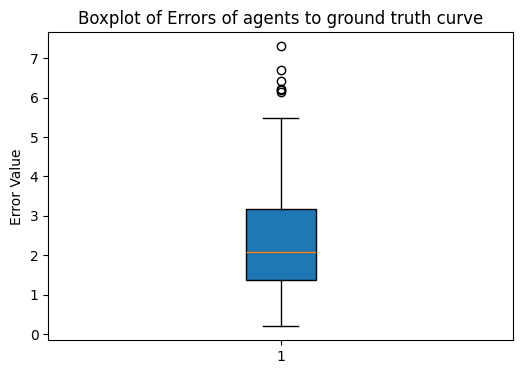

average error across all agents is 3.69075608253479 mm


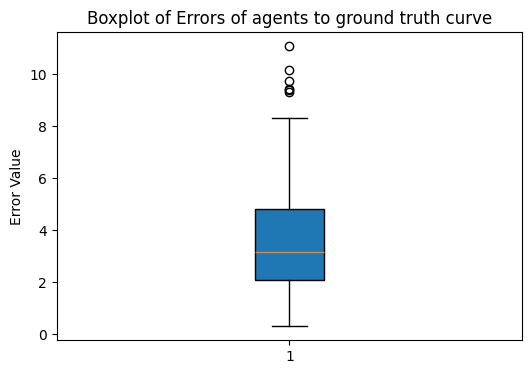

INFO:Logger:Average Validation Reward: -1.46


Average Total Reward: -1.46


INFO:Logger:Episode 61: Total Reward = 19.55 | Final Avg Distance 10.88 | Average error in mm [0.65 1.03 0.35 0.92 1.48 6.  ] | Worst Error in mm [ 1.1   1.75  0.6   1.54  2.49 10.13] Avg Closest Point = 1.07 | Avg Furthest Point = 33.71 | Finished Agents = tensor([0, 0, 1, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 62: Total Reward = 27.60 | Final Avg Distance 2.84 | Average error in mm [0.24 1.06 0.09 0.65 0.12 0.68] | Worst Error in mm [0.4  1.8  0.15 1.1  0.2  1.15] Avg Closest Point = 0.33 | Avg Furthest Point = 32.81 | Finished Agents = tensor([1, 0, 1, 0, 1, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 63: Total Reward = 5.42 | Final Avg Distance 21.23 | Average error in mm [1.23 3.96 1.73 8.63 7.07 6.62] | Worst Error in mm [ 2.07  6.68  2.93 14.57 11.93 11.16] Avg Closest Point = 2.30 | Avg Furthest Point = 33.63 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 64: Total Reward = 24.46 

average error across all agents is 2.317903518676758 mm


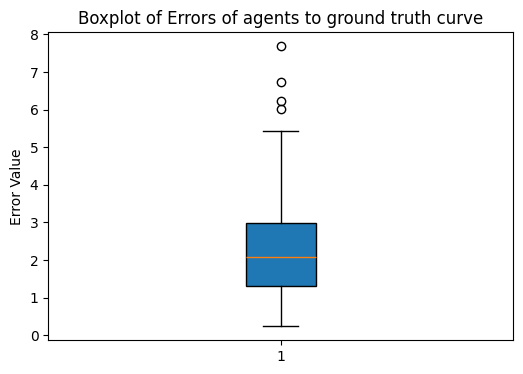

average error across all agents is 3.512333631515503 mm


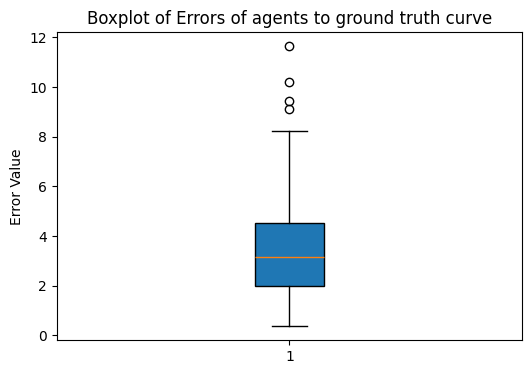

INFO:Logger:Average Validation Reward: -0.84


Average Total Reward: -0.84


INFO:Logger:Episode 71: Total Reward = 18.59 | Final Avg Distance 3.73 | Average error in mm [0.57 0.71 0.66 0.76 0.68 0.12] | Worst Error in mm [0.96 1.2  1.12 1.28 1.14 0.2 ] Avg Closest Point = 1.02 | Avg Furthest Point = 23.80 | Finished Agents = tensor([0, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 72: Total Reward = 19.22 | Final Avg Distance 3.10 | Average error in mm [0.12 1.09 0.64 0.56 0.21 0.11] | Worst Error in mm [0.2  1.84 1.08 0.94 0.36 0.18] Avg Closest Point = 0.17 | Avg Furthest Point = 25.45 | Finished Agents = tensor([1, 0, 0, 0, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 73: Total Reward = 20.68 | Final Avg Distance 5.73 | Average error in mm [0.11 0.66 0.68 0.78 1.35 1.86] | Worst Error in mm [0.18 1.12 1.15 1.32 2.29 3.13] Avg Closest Point = 0.86 | Avg Furthest Point = 28.59 | Finished Agents = tensor([1, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 74: Total Reward = 24.66 | Final Avg D

average error across all agents is 2.3536698818206787 mm


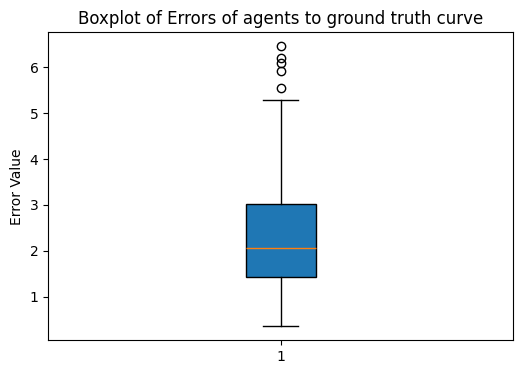

average error across all agents is 3.566530227661133 mm


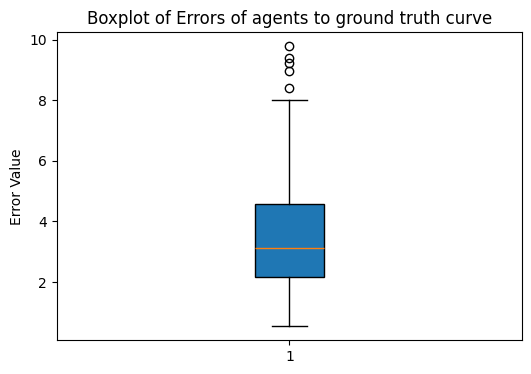

INFO:Logger:Average Validation Reward: -1.04


Average Total Reward: -1.04


INFO:Logger:Episode 81: Total Reward = 22.53 | Final Avg Distance 10.22 | Average error in mm [2.3  2.19 0.82 0.8  1.78 1.75] | Worst Error in mm [3.88 3.7  1.38 1.35 3.01 2.95] Avg Closest Point = 2.73 | Avg Furthest Point = 40.18 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 82: Total Reward = 28.68 | Final Avg Distance 4.07 | Average error in mm [0.89 0.52 0.37 0.62 0.84 0.39] | Worst Error in mm [1.5  0.87 0.63 1.05 1.41 0.66] Avg Closest Point = 1.38 | Avg Furthest Point = 35.36 | Finished Agents = tensor([0, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 83: Total Reward = 22.88 | Final Avg Distance 4.07 | Average error in mm [0.4  0.57 0.82 0.52 0.8  0.82] | Worst Error in mm [0.67 0.96 1.39 0.87 1.34 1.39] Avg Closest Point = 1.37 | Avg Furthest Point = 28.50 | Finished Agents = tensor([1, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 84: Total Reward = 23.86 | Final Avg 

average error across all agents is 2.3538436889648438 mm


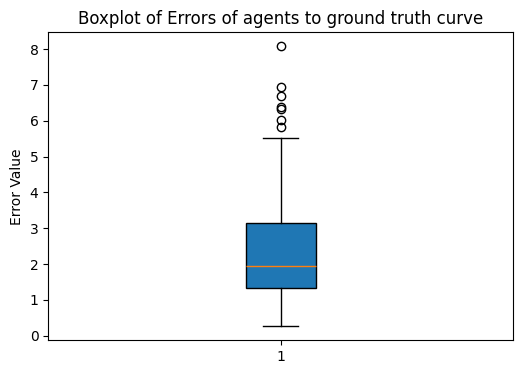

average error across all agents is 3.566793441772461 mm


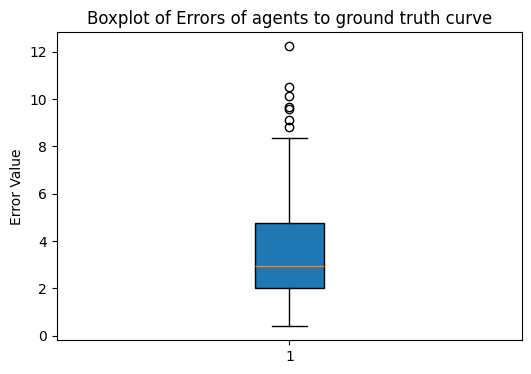

INFO:Logger:Average Validation Reward: -1.03


Average Total Reward: -1.03


INFO:Logger:Episode 91: Total Reward = 22.82 | Final Avg Distance 7.66 | Average error in mm [0.81 1.85 0.46 1.03 2.86 0.59] | Worst Error in mm [1.37 3.11 0.78 1.73 4.83 0.99] Avg Closest Point = 1.50 | Avg Furthest Point = 31.99 | Finished Agents = tensor([0, 0, 1, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 92: Total Reward = 27.81 | Final Avg Distance 2.66 | Average error in mm [0.11 0.69 0.47 0.58 0.35 0.35] | Worst Error in mm [0.19 1.16 0.79 0.98 0.58 0.58] Avg Closest Point = 0.33 | Avg Furthest Point = 32.56 | Finished Agents = tensor([1, 0, 0, 0, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 93: Total Reward = -5.62 | Final Avg Distance 31.47 | Average error in mm [ 1.5  12.23  9.95 12.49  5.63  7.99] | Worst Error in mm [ 2.54 20.63 16.78 21.07  9.5  13.48] Avg Closest Point = 3.82 | Avg Furthest Point = 54.58 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 94: Total Reward = 20.88 

average error across all agents is 2.2945120334625244 mm


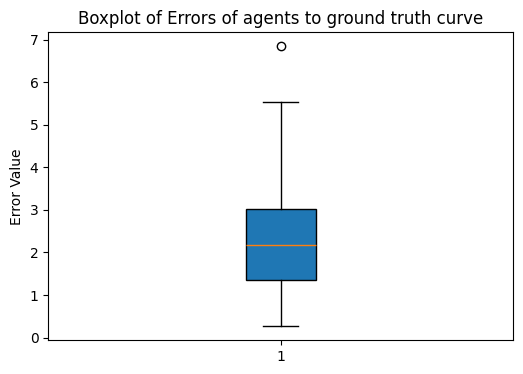

average error across all agents is 3.4768879413604736 mm


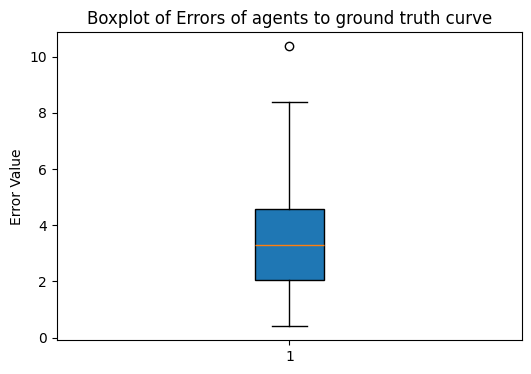

INFO:Logger:Average Validation Reward: -1.07


Average Total Reward: -1.07


/content/CardiacCTAnalysis/utils/logger.py:89: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["train_epochs"] = self.train_df
/content/CardiacCTAnalysis/utils/logger.py:90: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


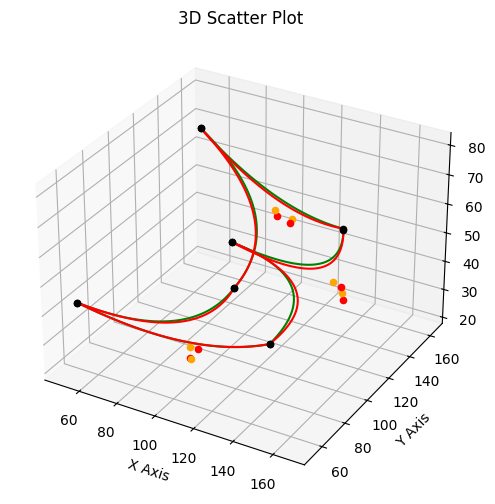

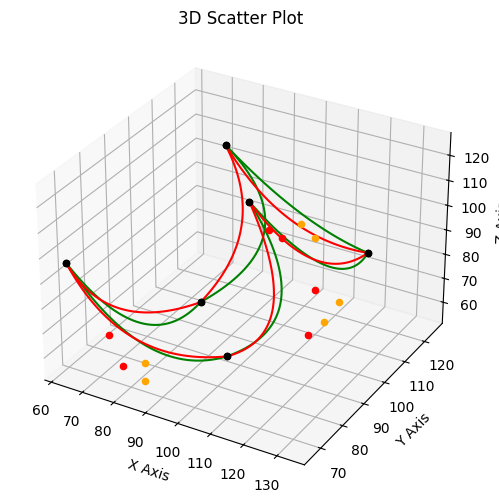

In [17]:
run_training(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = 0.22 | Final Avg Distance 12.02 | Average error in mm [0.7  0.53 0.5  4.79 3.72 3.49] | Worst Error in mm [1.06 0.81 0.76 7.25 5.64 5.28] Avg Closest Point = 9.90 | Avg Furthest Point = 13.85
INFO:Logger:Evaluation Episode 2: Total Reward = 3.04 | Final Avg Distance 10.93 | Average error in mm [0.92 1.42 1.01 0.61 2.44 3.78] | Worst Error in mm [1.39 2.15 1.53 0.93 3.69 5.72] Avg Closest Point = 9.18 | Avg Furthest Point = 15.28
INFO:Logger:Evaluation Episode 3: Total Reward = -3.59 | Final Avg Distance 18.16 | Average error in mm [2.46 6.13 5.75 0.92 2.87 4.76] | Worst Error in mm [3.72 9.29 8.71 1.39 4.35 7.21] Avg Closest Point = 12.73 | Avg Furthest Point = 19.66
INFO:Logger:Evaluation Episode 4: Total Reward = -3.75 | Final Avg Distance 11.52 | Average error in mm [3.56 2.79 0.8  3.39 1.82 0.76] | Worst Error in mm [5.4  4.23 1.21 5.14 2.77 1.15] Avg Closest Point = 6.71 | Avg Furthest Point = 12.71
INFO:Logger:Evaluation Episode 5:

average error across all agents is 2.2170984745025635 mm


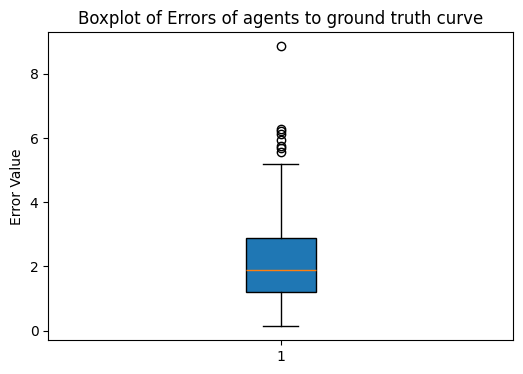

average error across all agents is 3.3595829010009766 mm


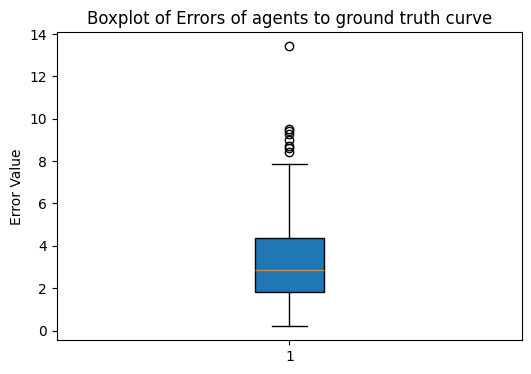

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


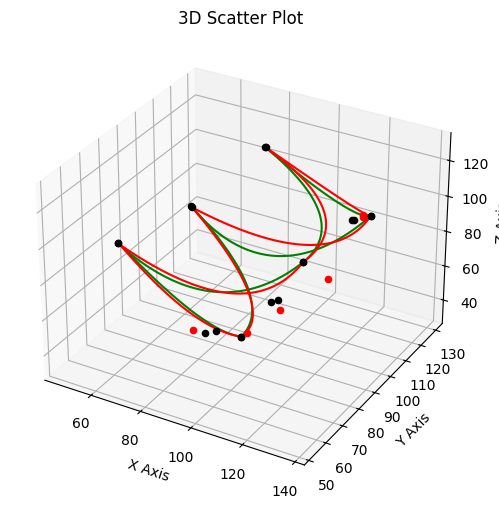

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = 1.16 | Final Avg Distance 15.00 | Average error in mm [2.49 1.85 5.91 1.99 1.69 3.15] | Worst Error in mm [3.78 2.8  8.95 3.02 2.56 4.78] Avg Closest Point = 12.20 | Avg Furthest Point = 18.53
INFO:Logger:Evaluation Episode 2: Total Reward = 3.62 | Final Avg Distance 12.20 | Average error in mm [3.48 3.56 1.11 2.2  1.09 0.87] | Worst Error in mm [5.27 5.39 1.69 3.33 1.65 1.32] Avg Closest Point = 10.55 | Avg Furthest Point = 16.02
INFO:Logger:Evaluation Episode 3: Total Reward = -3.63 | Final Avg Distance 15.62 | Average error in mm [7.22 4.33 1.99 6.62 3.54 0.48] | Worst Error in mm [10.94  6.56  3.01 10.04  5.37  0.72] Avg Closest Point = 11.07 | Avg Furthest Point = 15.78
INFO:Logger:Evaluation Episode 4: Total Reward = 3.78 | Final Avg Distance 18.06 | Average error in mm [1.31 1.87 3.16 4.47 3.16 4.33] | Worst Error in mm [1.99 2.84 4.79 6.77 4.79 6.57] Avg Closest Point = 16.65 | Avg Furthest Point = 22.47
INFO:Logger:Evaluation Ep

average error across all agents is 2.755047559738159 mm


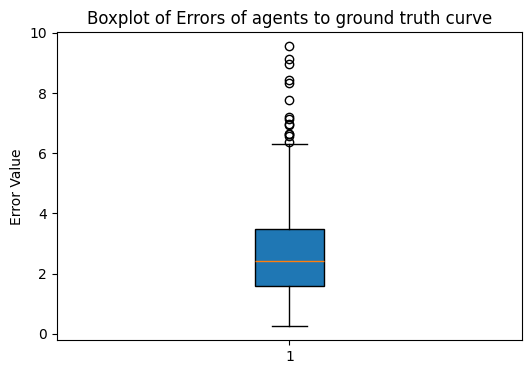

average error across all agents is 4.174740791320801 mm


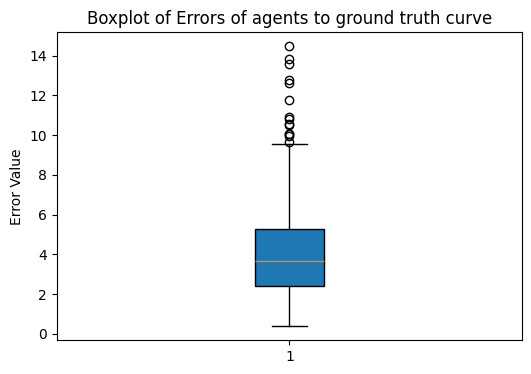

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


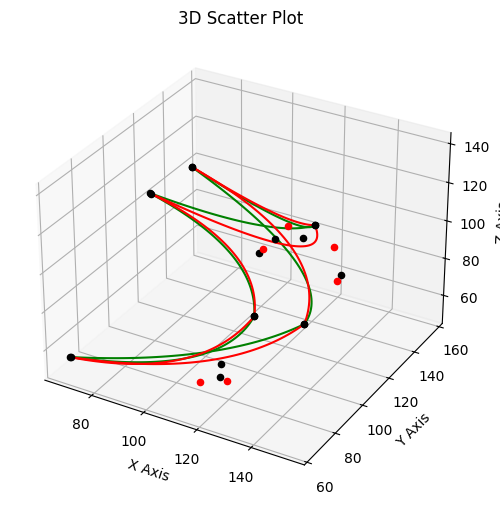

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

Experiment 4: CommNet - work alone

In [18]:
config.experiment = Experiment.WORK_ALONE
config.model_type = "CommNet"

INFO:Logger:Episode 1: Total Reward = -9.47 | Final Avg Distance 35.21 | Average error in mm [15.88  7.23 10.55  7.99 12.8   6.5 ] | Worst Error in mm [26.79 12.2  17.81 13.49 21.6  10.98] Avg Closest Point = 7.66 | Avg Furthest Point = 50.89 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 2: Total Reward = 0.42 | Final Avg Distance 25.32 | Average error in mm [ 6.64  6.4   6.68 15.53  1.21  7.44] | Worst Error in mm [11.21 10.8  11.27 26.21  2.04 12.55] Avg Closest Point = 4.02 | Avg Furthest Point = 42.82 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 3: Total Reward = -8.14 | Final Avg Distance 29.84 | Average error in mm [3.26 1.5  2.73 5.76 9.54 5.76] | Worst Error in mm [ 5.5   2.53  4.6   9.72 16.1   9.73] Avg Closest Point = 5.86 | Avg Furthest Point = 38.48 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 4: Total 

average error across all agents is 2.564934253692627 mm


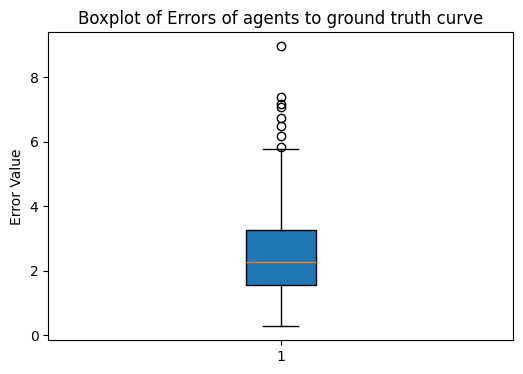

average error across all agents is 3.886660575866699 mm


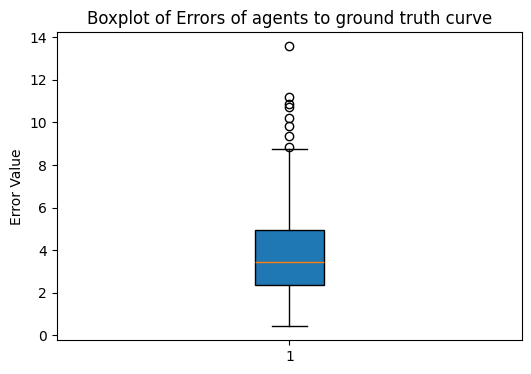

INFO:Logger:Average Validation Reward: -2.10
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -2.10


INFO:Logger:Episode 11: Total Reward = 17.25 | Final Avg Distance 17.01 | Average error in mm [0.87 7.67 2.18 1.79 1.07 0.51] | Worst Error in mm [ 1.46 12.94  3.67  3.02  1.81  0.85] Avg Closest Point = 1.59 | Avg Furthest Point = 42.22 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 12: Total Reward = 30.83 | Final Avg Distance 3.43 | Average error in mm [0.87 0.21 0.51 0.57 0.69 0.78] | Worst Error in mm [1.46 0.35 0.85 0.96 1.16 1.31] Avg Closest Point = 0.83 | Avg Furthest Point = 36.53 | Finished Agents = tensor([0, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 13: Total Reward = 6.39 | Final Avg Distance 15.44 | Average error in mm [11.11  0.68  1.7   0.43  0.78  0.95] | Worst Error in mm [18.75  1.16  2.87  0.72  1.31  1.6 ] Avg Closest Point = 1.51 | Avg Furthest Point = 32.76 | Finished Agents = tensor([0, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 14: Total Reward = 

average error across all agents is 2.46089243888855 mm


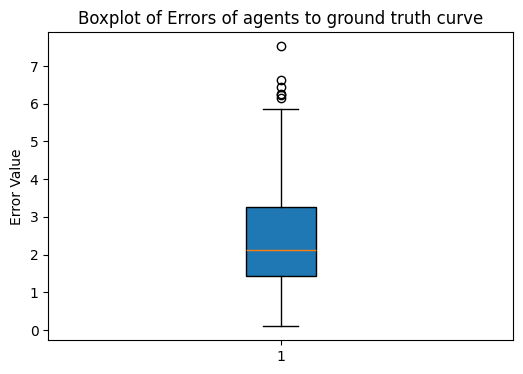

average error across all agents is 3.7290053367614746 mm


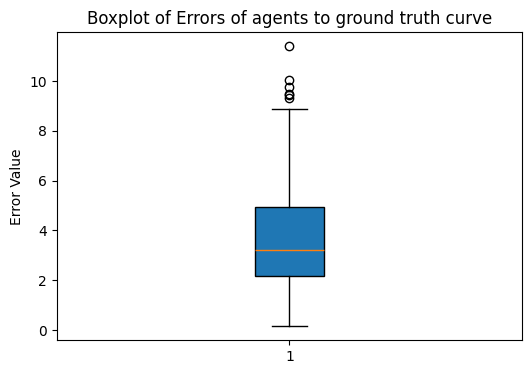

INFO:Logger:Average Validation Reward: -1.78
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -1.78


INFO:Logger:Episode 21: Total Reward = 22.81 | Final Avg Distance 7.76 | Average error in mm [1.21 0.77 0.68 0.57 0.65 3.54] | Worst Error in mm [2.05 1.3  1.14 0.96 1.1  5.97] Avg Closest Point = 1.21 | Avg Furthest Point = 31.98 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 22: Total Reward = 26.54 | Final Avg Distance 4.03 | Average error in mm [0.34 0.32 1.31 0.56 0.44 0.91] | Worst Error in mm [0.58 0.54 2.21 0.94 0.74 1.54] Avg Closest Point = 0.67 | Avg Furthest Point = 31.16 | Finished Agents = tensor([1, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 23: Total Reward = 13.28 | Final Avg Distance 12.47 | Average error in mm [1.04 1.72 1.16 0.57 0.45 7.94] | Worst Error in mm [ 1.76  2.9   1.97  0.97  0.77 13.4 ] Avg Closest Point = 0.90 | Avg Furthest Point = 32.39 | Finished Agents = tensor([0, 0, 0, 0, 1, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 24: Total Reward = 18.06 | Fina

average error across all agents is 2.5804176330566406 mm


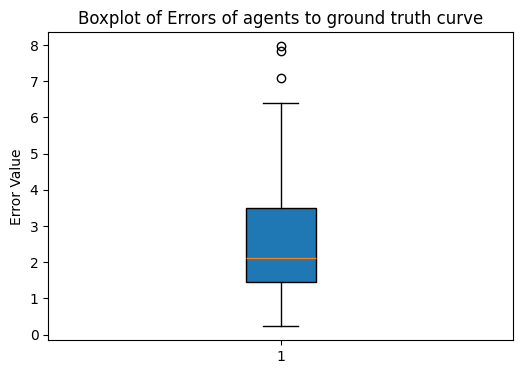

average error across all agents is 3.9101221561431885 mm


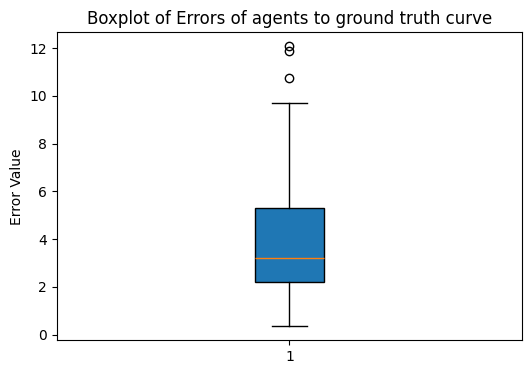

INFO:Logger:Average Validation Reward: -2.21


Average Total Reward: -2.21


INFO:Logger:Episode 31: Total Reward = 17.77 | Final Avg Distance 9.10 | Average error in mm [0.71 4.32 0.72 1.32 2.03 0.36] | Worst Error in mm [1.2  7.29 1.21 2.23 3.43 0.6 ] Avg Closest Point = 2.10 | Avg Furthest Point = 32.69 | Finished Agents = tensor([0, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 32: Total Reward = 23.20 | Final Avg Distance 3.68 | Average error in mm [0.72 0.24 0.72 1.08 0.6  0.6 ] | Worst Error in mm [1.22 0.4  1.22 1.82 1.01 1.01] Avg Closest Point = 0.67 | Avg Furthest Point = 29.15 | Finished Agents = tensor([0, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 33: Total Reward = 27.79 | Final Avg Distance 3.14 | Average error in mm [0.34 0.89 0.23 0.54 0.87 0.21] | Worst Error in mm [0.58 1.5  0.38 0.9  1.46 0.36] Avg Closest Point = 1.34 | Avg Furthest Point = 33.30 | Finished Agents = tensor([1, 0, 1, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 34: Total Reward = 27.50 | Final Avg D

average error across all agents is 2.3548429012298584 mm


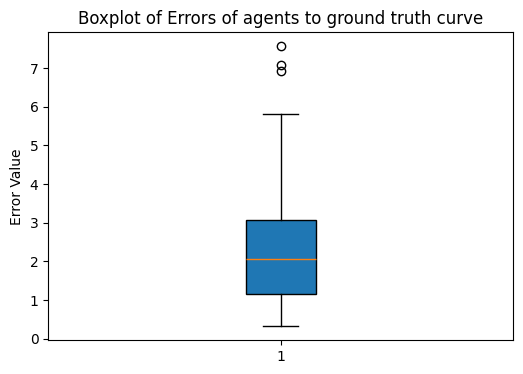

average error across all agents is 3.568308115005493 mm


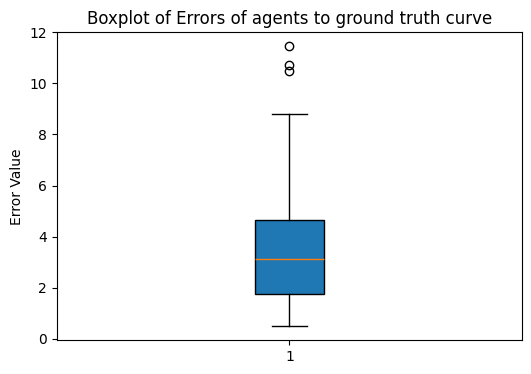

INFO:Logger:Average Validation Reward: -1.38
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -1.38


INFO:Logger:Episode 41: Total Reward = 23.63 | Final Avg Distance 3.74 | Average error in mm [0.3  0.7  0.61 0.98 0.5  0.5 ] | Worst Error in mm [0.5  1.17 1.02 1.65 0.85 0.85] Avg Closest Point = 1.74 | Avg Furthest Point = 29.49 | Finished Agents = tensor([1, 0, 0, 0, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 42: Total Reward = 24.08 | Final Avg Distance 3.29 | Average error in mm [0.1  0.52 0.81 0.4  0.47 0.49] | Worst Error in mm [0.17 0.87 1.37 0.67 0.8  0.82] Avg Closest Point = 1.07 | Avg Furthest Point = 29.92 | Finished Agents = tensor([1, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 43: Total Reward = 20.97 | Final Avg Distance 5.71 | Average error in mm [2.22 1.9  0.89 0.86 0.5  1.64] | Worst Error in mm [3.75 3.21 1.49 1.46 0.84 2.77] Avg Closest Point = 1.78 | Avg Furthest Point = 32.42 | Finished Agents = tensor([0, 0, 0, 0, 1, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 44: Total Reward = 22.78 | Final Avg D

average error across all agents is 2.2691564559936523 mm


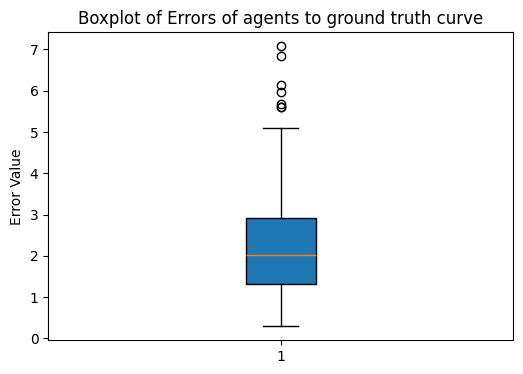

average error across all agents is 3.438466787338257 mm


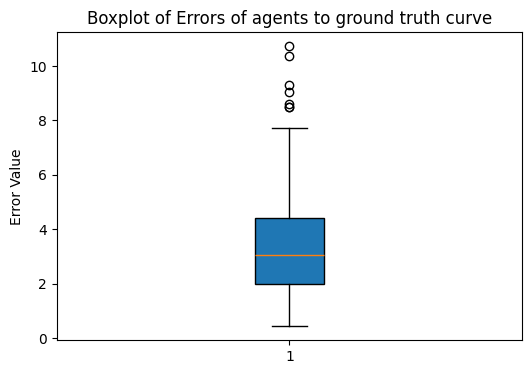

INFO:Logger:Average Validation Reward: -0.84
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -0.84


INFO:Logger:Episode 51: Total Reward = -16.41 | Final Avg Distance 38.12 | Average error in mm [3.88 7.07 0.96 8.83 8.51 9.48] | Worst Error in mm [ 6.55 11.93  1.62 14.9  14.37 16.  ] Avg Closest Point = 2.64 | Avg Furthest Point = 44.31 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 52: Total Reward = 9.77 | Final Avg Distance 11.95 | Average error in mm [2.2  6.1  0.96 0.99 0.9  0.36] | Worst Error in mm [ 3.72 10.29  1.62  1.67  1.51  0.61] Avg Closest Point = 1.17 | Avg Furthest Point = 25.87 | Finished Agents = tensor([0, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 53: Total Reward = 9.54 | Final Avg Distance 18.81 | Average error in mm [0.68 4.98 5.78 0.88 9.59 3.46] | Worst Error in mm [ 1.15  8.41  9.76  1.49 16.19  5.84] Avg Closest Point = 2.32 | Avg Furthest Point = 34.02 | Finished Agents = tensor([0, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 54: Total Reward =

average error across all agents is 2.442056655883789 mm


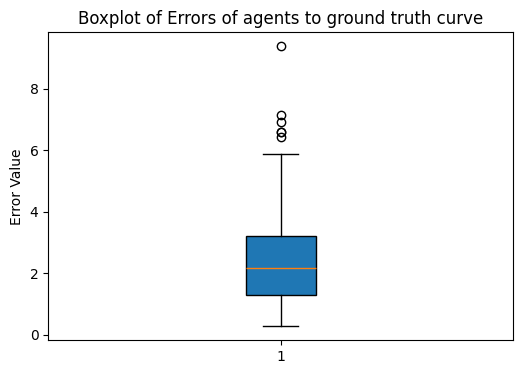

average error across all agents is 3.700463056564331 mm


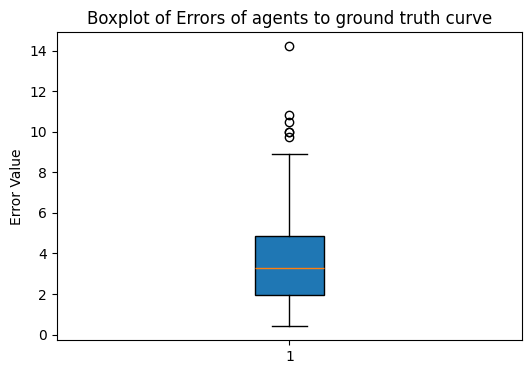

INFO:Logger:Average Validation Reward: -1.51


Average Total Reward: -1.51


INFO:Logger:Episode 61: Total Reward = 5.54 | Final Avg Distance 14.39 | Average error in mm [ 1.55  2.19  2.87 10.95  2.56  0.79] | Worst Error in mm [ 2.61  3.69  4.84 18.48  4.33  1.34] Avg Closest Point = 3.09 | Avg Furthest Point = 27.54 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 62: Total Reward = 16.71 | Final Avg Distance 3.22 | Average error in mm [0.53 0.26 0.6  0.66 0.94 1.09] | Worst Error in mm [0.89 0.45 1.02 1.11 1.59 1.85] Avg Closest Point = 0.84 | Avg Furthest Point = 25.49 | Finished Agents = tensor([0, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 63: Total Reward = 21.04 | Final Avg Distance 9.38 | Average error in mm [0.35 1.12 0.38 4.43 2.07 0.68] | Worst Error in mm [0.6  1.89 0.65 7.48 3.49 1.15] Avg Closest Point = 1.26 | Avg Furthest Point = 33.70 | Finished Agents = tensor([1, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 64: Total Reward = 19.36 |

average error across all agents is 2.3412230014801025 mm


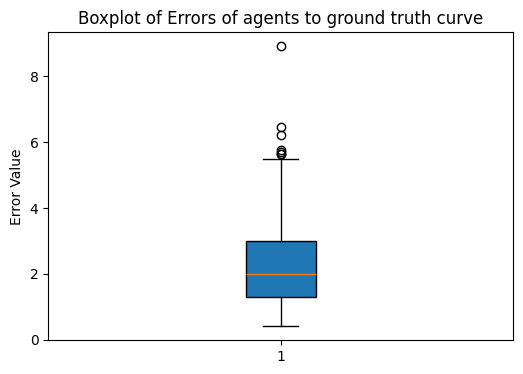

average error across all agents is 3.5476698875427246 mm


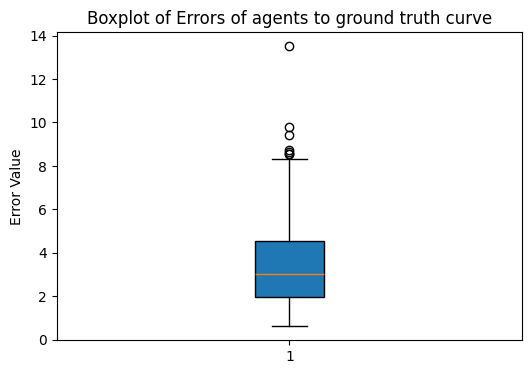

INFO:Logger:Average Validation Reward: -1.14


Average Total Reward: -1.14


INFO:Logger:Episode 71: Total Reward = -4.26 | Final Avg Distance 35.74 | Average error in mm [16.28  5.29  1.04  4.02  1.1   7.5 ] | Worst Error in mm [27.47  8.92  1.75  6.78  1.85 12.65] Avg Closest Point = 4.47 | Avg Furthest Point = 54.80 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 72: Total Reward = 6.63 | Final Avg Distance 24.84 | Average error in mm [13.    1.59  0.98  0.52  1.25  5.35] | Worst Error in mm [21.93  2.68  1.66  0.88  2.11  9.02] Avg Closest Point = 1.50 | Avg Furthest Point = 45.17 | Finished Agents = tensor([0, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 73: Total Reward = 12.95 | Final Avg Distance 23.54 | Average error in mm [1.7  2.67 2.22 6.87 1.55 4.99] | Worst Error in mm [ 2.87  4.5   3.75 11.6   2.62  8.42] Avg Closest Point = 5.75 | Avg Furthest Point = 43.47 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 74: To

average error across all agents is 2.505098819732666 mm


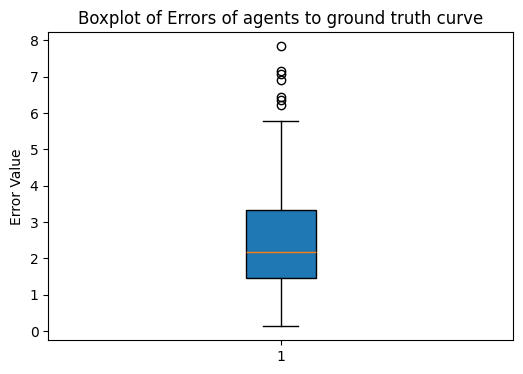

average error across all agents is 3.795991897583008 mm


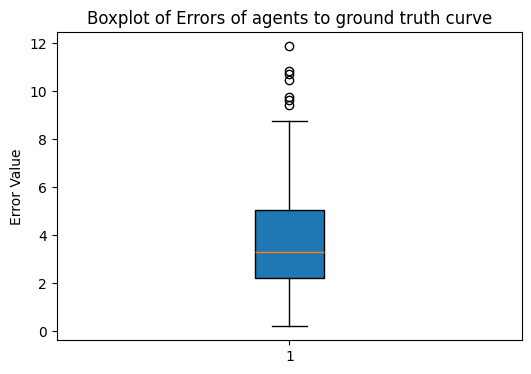

INFO:Logger:Average Validation Reward: -1.52


Average Total Reward: -1.52


INFO:Logger:Episode 81: Total Reward = 18.47 | Final Avg Distance 10.84 | Average error in mm [2.9  1.79 0.33 5.13 0.24 0.9 ] | Worst Error in mm [4.9  3.02 0.55 8.66 0.4  1.51] Avg Closest Point = 1.57 | Avg Furthest Point = 37.82 | Finished Agents = tensor([0, 0, 1, 0, 1, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 82: Total Reward = 23.43 | Final Avg Distance 5.87 | Average error in mm [0.81 1.02 0.33 2.71 0.63 0.18] | Worst Error in mm [1.36 1.72 0.55 4.58 1.06 0.3 ] Avg Closest Point = 1.26 | Avg Furthest Point = 29.95 | Finished Agents = tensor([0, 0, 1, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 83: Total Reward = 15.75 | Final Avg Distance 10.23 | Average error in mm [2.07 1.03 2.01 0.8  1.09 1.33] | Worst Error in mm [3.49 1.74 3.39 1.35 1.84 2.25] Avg Closest Point = 1.55 | Avg Furthest Point = 28.07 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 84: Total Reward = 18.87 | Final Avg

average error across all agents is 2.4362599849700928 mm


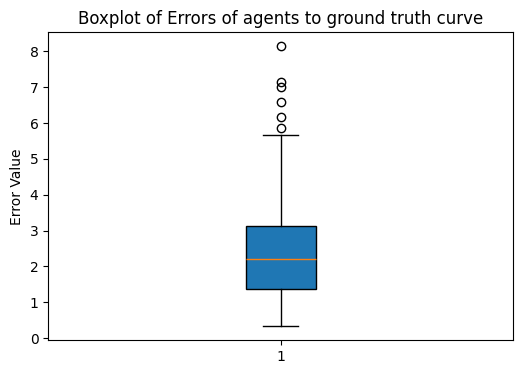

average error across all agents is 3.6916794776916504 mm


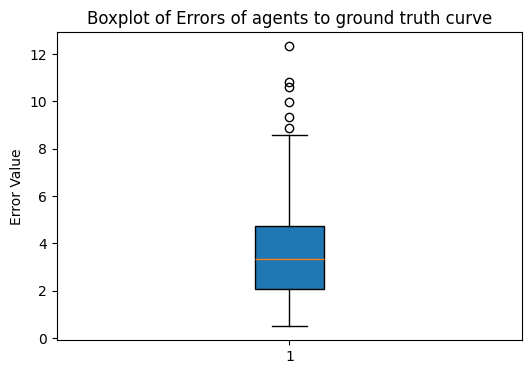

INFO:Logger:Average Validation Reward: -1.78


Average Total Reward: -1.78


INFO:Logger:Episode 91: Total Reward = 3.16 | Final Avg Distance 23.35 | Average error in mm [8.02 2.82 0.65 3.75 7.01 0.99] | Worst Error in mm [13.53  4.75  1.1   6.33 11.83  1.68] Avg Closest Point = 5.40 | Avg Furthest Point = 38.20 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 92: Total Reward = 19.71 | Final Avg Distance 6.80 | Average error in mm [0.34 0.9  0.65 3.1  1.2  0.56] | Worst Error in mm [0.58 1.52 1.1  5.23 2.02 0.94] Avg Closest Point = 2.46 | Avg Furthest Point = 28.40 | Finished Agents = tensor([1, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 93: Total Reward = 13.84 | Final Avg Distance 13.08 | Average error in mm [0.96 1.02 0.92 4.33 3.73 0.73] | Worst Error in mm [1.62 1.73 1.56 7.3  6.29 1.23] Avg Closest Point = 2.34 | Avg Furthest Point = 32.25 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 94: Total Reward = 23.44 | Fina

average error across all agents is 3.1211190223693848 mm


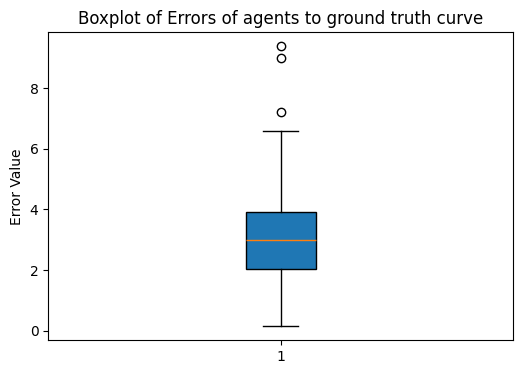

average error across all agents is 4.729450702667236 mm


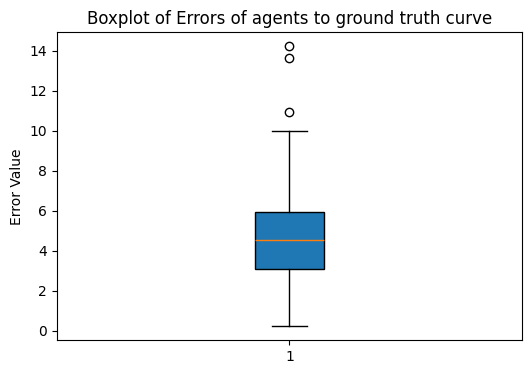

INFO:Logger:Average Validation Reward: -5.35


Average Total Reward: -5.35


/content/CardiacCTAnalysis/utils/logger.py:89: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["train_epochs"] = self.train_df
/content/CardiacCTAnalysis/utils/logger.py:90: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


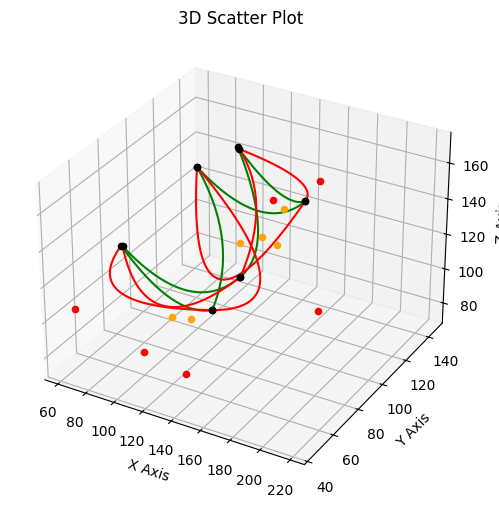

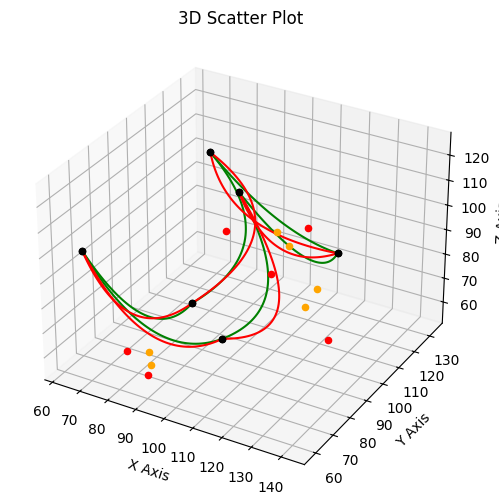

In [19]:
run_training(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = -1.60 | Final Avg Distance 13.83 | Average error in mm [2.59 1.52 1.76 1.93 2.98 2.35] | Worst Error in mm [3.93 2.31 2.67 2.92 4.52 3.56] Avg Closest Point = 9.82 | Avg Furthest Point = 15.42
INFO:Logger:Evaluation Episode 2: Total Reward = 3.26 | Final Avg Distance 10.71 | Average error in mm [0.9  2.03 1.64 0.8  0.61 3.36] | Worst Error in mm [1.37 3.08 2.48 1.22 0.93 5.1 ] Avg Closest Point = 10.61 | Avg Furthest Point = 14.25
INFO:Logger:Evaluation Episode 3: Total Reward = -2.50 | Final Avg Distance 17.07 | Average error in mm [2.32 2.97 2.84 3.63 6.12 1.23] | Worst Error in mm [3.51 4.49 4.3  5.5  9.27 1.86] Avg Closest Point = 11.31 | Avg Furthest Point = 19.94
INFO:Logger:Evaluation Episode 4: Total Reward = -6.68 | Final Avg Distance 14.45 | Average error in mm [1.8  1.99 3.47 1.23 2.33 2.81] | Worst Error in mm [2.73 3.01 5.26 1.87 3.53 4.26] Avg Closest Point = 7.38 | Avg Furthest Point = 15.01
INFO:Logger:Evaluation Episode 

average error across all agents is 2.4393980503082275 mm


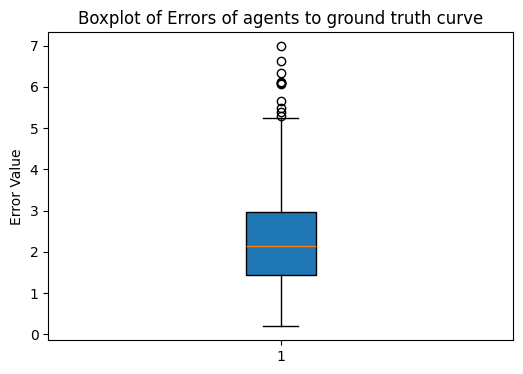

average error across all agents is 3.6964352130889893 mm


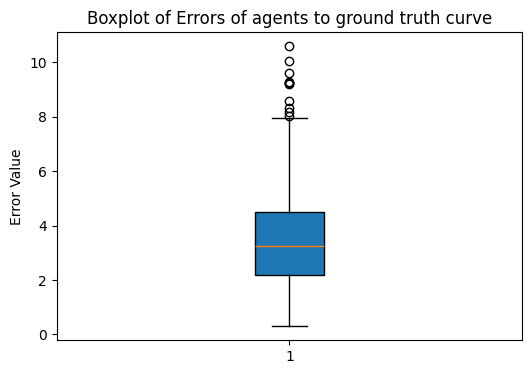

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


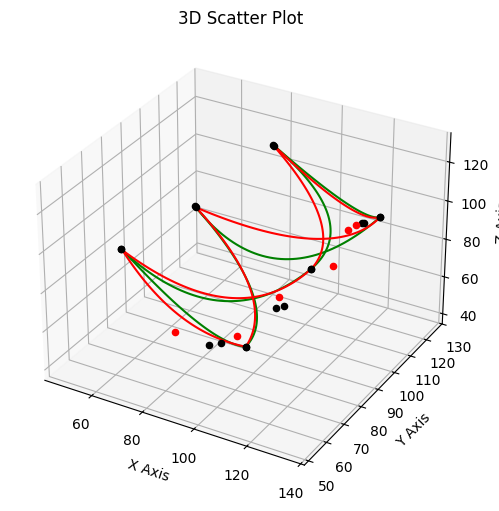

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = 1.52 | Final Avg Distance 14.64 | Average error in mm [1.2  1.36 4.77 4.01 1.73 3.09] | Worst Error in mm [1.82 2.06 7.23 6.08 2.62 4.68] Avg Closest Point = 11.80 | Avg Furthest Point = 18.32
INFO:Logger:Evaluation Episode 2: Total Reward = 0.75 | Final Avg Distance 15.07 | Average error in mm [2.82 4.62 1.09 0.71 2.68 1.66] | Worst Error in mm [4.27 7.   1.65 1.08 4.06 2.52] Avg Closest Point = 11.95 | Avg Furthest Point = 17.02
INFO:Logger:Evaluation Episode 3: Total Reward = -2.52 | Final Avg Distance 14.51 | Average error in mm [4.16 4.17 1.99 3.73 4.45 3.61] | Worst Error in mm [6.31 6.31 3.01 5.65 6.74 5.48] Avg Closest Point = 11.18 | Avg Furthest Point = 15.57
INFO:Logger:Evaluation Episode 4: Total Reward = 1.05 | Final Avg Distance 20.80 | Average error in mm [1.03 2.61 4.73 3.54 4.03 4.58] | Worst Error in mm [1.56 3.95 7.17 5.36 6.11 6.94] Avg Closest Point = 18.17 | Avg Furthest Point = 22.74
INFO:Logger:Evaluation Episode 

average error across all agents is 2.959026336669922 mm


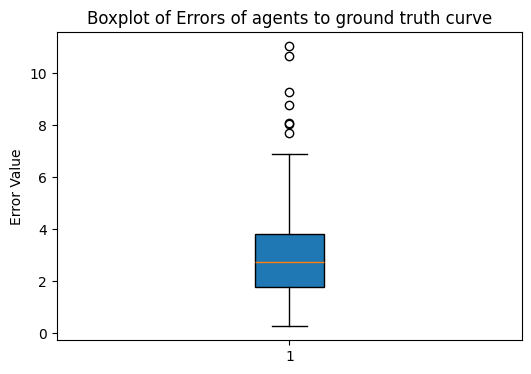

average error across all agents is 4.483830451965332 mm


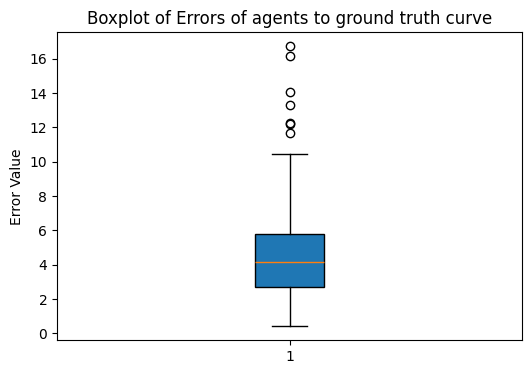

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


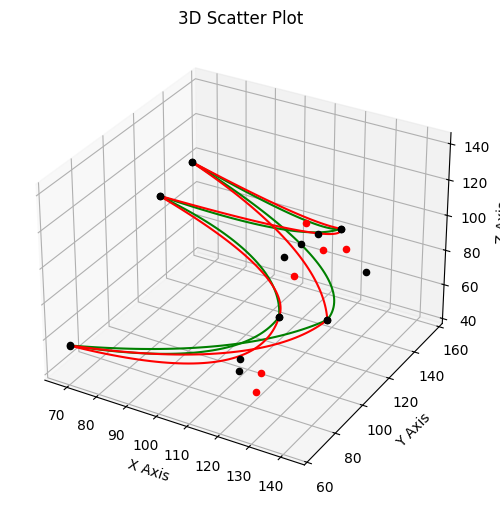

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

Experiment 5: CommNet - share positions

In [20]:
config.experiment = Experiment.SHARE_POSITIONS

INFO:Logger:Episode 1: Total Reward = 1.97 | Final Avg Distance 24.89 | Average error in mm [ 6.01  4.1  10.34  1.82  1.29  2.85] | Worst Error in mm [10.14  6.91 17.44  3.08  2.18  4.81] Avg Closest Point = 8.92 | Avg Furthest Point = 48.33 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 2: Total Reward = -19.37 | Final Avg Distance 46.23 | Average error in mm [14.38  5.92  8.46  8.2   6.82  5.92] | Worst Error in mm [24.27 10.   14.27 13.83 11.5   9.98] Avg Closest Point = 6.81 | Avg Furthest Point = 61.27 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 3: Total Reward = -15.04 | Final Avg Distance 44.98 | Average error in mm [ 5.    6.16 15.05  3.55  7.1   2.12] | Worst Error in mm [ 8.43 10.39 25.4   5.99 11.97  3.58] Avg Closest Point = 7.60 | Avg Furthest Point = 64.38 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 4

average error across all agents is 2.7622194290161133 mm


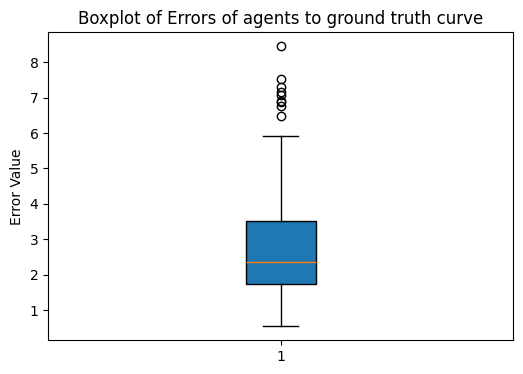

average error across all agents is 4.18560791015625 mm


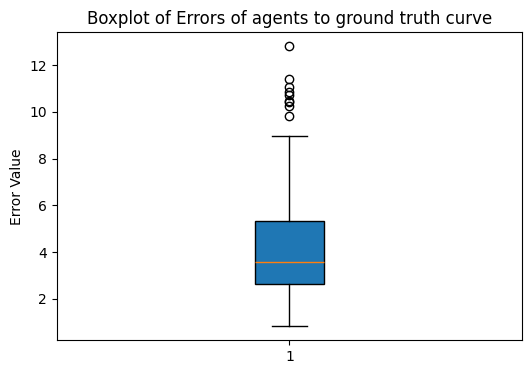

INFO:Logger:Average Validation Reward: -3.06
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -3.06


INFO:Logger:Episode 11: Total Reward = 0.18 | Final Avg Distance 11.47 | Average error in mm [4.16 3.73 4.93 2.9  2.79 3.83] | Worst Error in mm [7.02 6.3  8.33 4.9  4.7  6.46] Avg Closest Point = 1.83 | Avg Furthest Point = 22.72 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 12: Total Reward = 7.50 | Final Avg Distance 4.15 | Average error in mm [1.72 1.42 0.83 1.13 1.85 0.92] | Worst Error in mm [2.9  2.4  1.4  1.9  3.12 1.56] Avg Closest Point = 0.74 | Avg Furthest Point = 12.83 | Finished Agents = tensor([0, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 13: Total Reward = 2.09 | Final Avg Distance 22.21 | Average error in mm [ 2.15  3.76  2.99 10.6   3.52  2.14] | Worst Error in mm [ 3.62  6.34  5.05 17.88  5.94  3.62] Avg Closest Point = 4.56 | Avg Furthest Point = 40.22 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 14: Total Reward = 15.10 | 

average error across all agents is 2.4034836292266846 mm


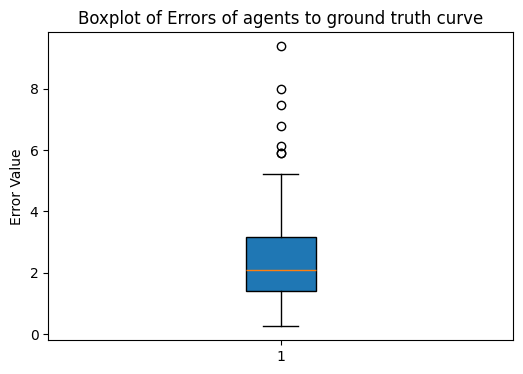

average error across all agents is 3.6420137882232666 mm


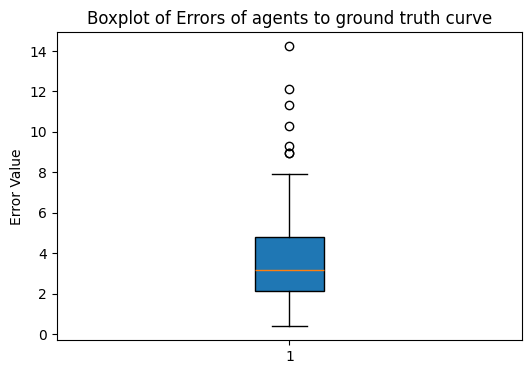

INFO:Logger:Average Validation Reward: -1.22
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -1.22


INFO:Logger:Episode 21: Total Reward = -3.89 | Final Avg Distance 31.67 | Average error in mm [3.52 4.26 6.29 3.1  3.96 7.72] | Worst Error in mm [ 5.94  7.18 10.62  5.23  6.69 13.03] Avg Closest Point = 4.35 | Avg Furthest Point = 43.41 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 22: Total Reward = 22.96 | Final Avg Distance 4.82 | Average error in mm [1.12 0.12 0.59 0.95 0.74 0.65] | Worst Error in mm [1.9  0.2  1.   1.6  1.25 1.1 ] Avg Closest Point = 1.00 | Avg Furthest Point = 30.08 | Finished Agents = tensor([0, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 23: Total Reward = 25.08 | Final Avg Distance 13.15 | Average error in mm [1.14 2.07 2.3  1.61 1.66 2.84] | Worst Error in mm [1.92 3.49 3.87 2.72 2.81 4.79] Avg Closest Point = 1.78 | Avg Furthest Point = 48.10 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 24: Total Reward = 33.01 | Fin

average error across all agents is 2.25608229637146 mm


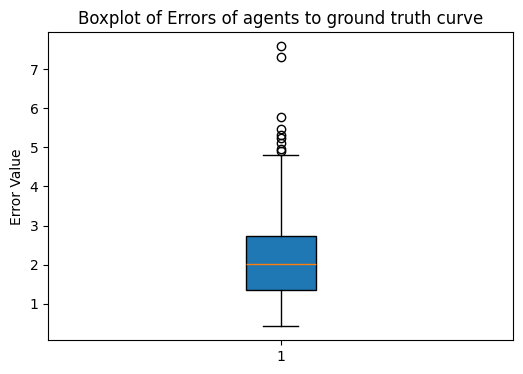

average error across all agents is 3.4186551570892334 mm


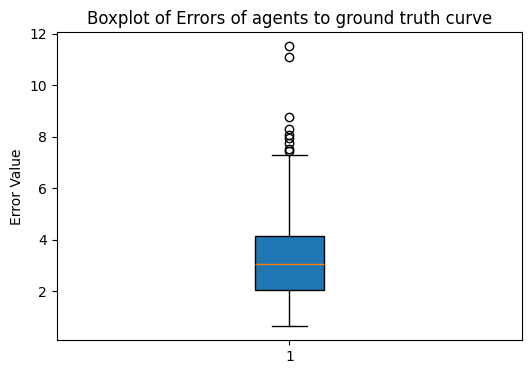

INFO:Logger:Average Validation Reward: -0.68
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -0.68


INFO:Logger:Episode 31: Total Reward = 19.53 | Final Avg Distance 6.44 | Average error in mm [1.26 1.38 1.15 1.84 0.69 0.46] | Worst Error in mm [2.12 2.32 1.95 3.1  1.16 0.77] Avg Closest Point = 0.97 | Avg Furthest Point = 28.15 | Finished Agents = tensor([0, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 32: Total Reward = 22.95 | Final Avg Distance 3.03 | Average error in mm [0.58 0.47 0.23 0.69 0.23 0.7 ] | Worst Error in mm [0.97 0.79 0.38 1.17 0.38 1.18] Avg Closest Point = 0.33 | Avg Furthest Point = 26.98 | Finished Agents = tensor([0, 0, 1, 0, 1, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 33: Total Reward = 6.24 | Final Avg Distance 19.38 | Average error in mm [1.54 1.43 7.21 2.14 1.55 5.08] | Worst Error in mm [ 2.6   2.41 12.16  3.61  2.62  8.57] Avg Closest Point = 1.46 | Avg Furthest Point = 29.84 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 34: Total Reward = 20.45 | Final

average error across all agents is 2.3818576335906982 mm


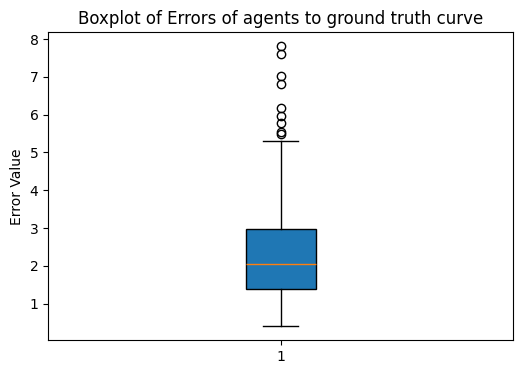

average error across all agents is 3.609243392944336 mm


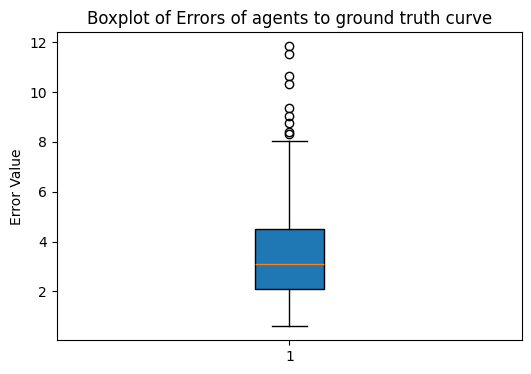

INFO:Logger:Average Validation Reward: -0.91


Average Total Reward: -0.91


INFO:Logger:Episode 41: Total Reward = -18.66 | Final Avg Distance 51.09 | Average error in mm [14.18  6.76  1.28 15.12  4.77  5.99] | Worst Error in mm [23.93 11.41  2.16 25.52  8.06 10.11] Avg Closest Point = 6.05 | Avg Furthest Point = 65.52 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 42: Total Reward = 20.43 | Final Avg Distance 11.99 | Average error in mm [4.82 0.42 1.52 0.42 1.43 1.46] | Worst Error in mm [8.14 0.71 2.57 0.71 2.42 2.46] Avg Closest Point = 2.02 | Avg Furthest Point = 35.00 | Finished Agents = tensor([0, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 43: Total Reward = -10.27 | Final Avg Distance 41.75 | Average error in mm [ 4.97  7.93 13.87  6.17  3.14  6.85] | Worst Error in mm [ 8.39 13.38 23.4  10.41  5.3  11.56] Avg Closest Point = 3.58 | Avg Furthest Point = 47.16 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 44: Total

average error across all agents is 2.371738910675049 mm


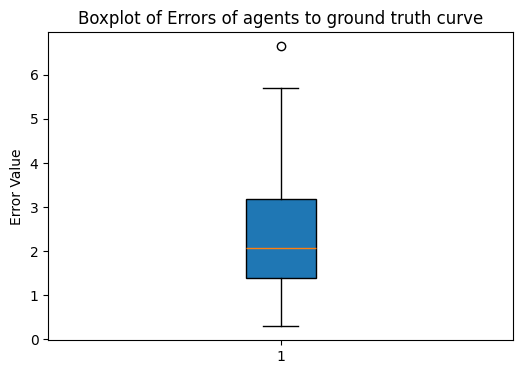

average error across all agents is 3.5939102172851562 mm


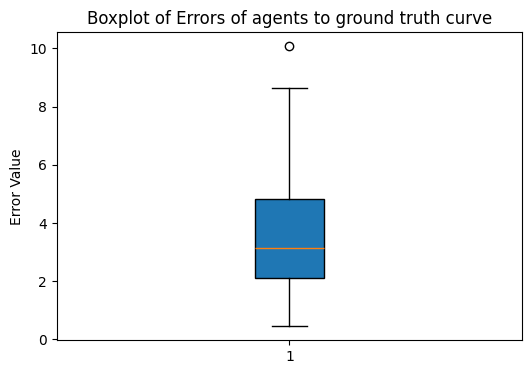

INFO:Logger:Average Validation Reward: -1.25


Average Total Reward: -1.25


INFO:Logger:Episode 51: Total Reward = -29.30 | Final Avg Distance 40.81 | Average error in mm [13.58  5.38  7.78  9.74 26.48 12.3 ] | Worst Error in mm [22.91  9.08 13.12 16.43 44.68 20.75] Avg Closest Point = 4.64 | Avg Furthest Point = 51.14 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 52: Total Reward = -25.86 | Final Avg Distance 37.37 | Average error in mm [18.54  7.06 18.83  3.77  7.48  5.03] | Worst Error in mm [31.29 11.91 31.78  6.36 12.63  8.48] Avg Closest Point = 2.44 | Avg Furthest Point = 50.82 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 53: Total Reward = 8.64 | Final Avg Distance 14.80 | Average error in mm [11.43  0.56  2.86  1.06  3.47  0.5 ] | Worst Error in mm [19.28  0.94  4.82  1.79  5.86  0.85] Avg Closest Point = 1.94 | Avg Furthest Point = 30.22 | Finished Agents = tensor([0, 1, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episod

average error across all agents is 2.309502601623535 mm


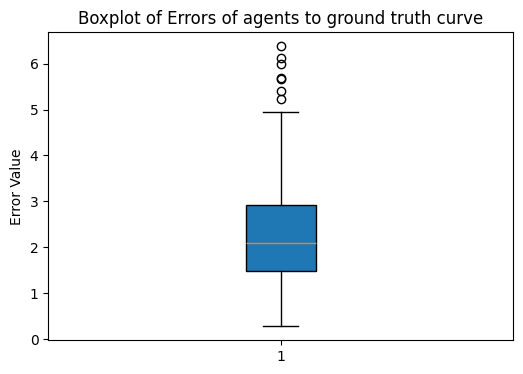

average error across all agents is 3.499603271484375 mm


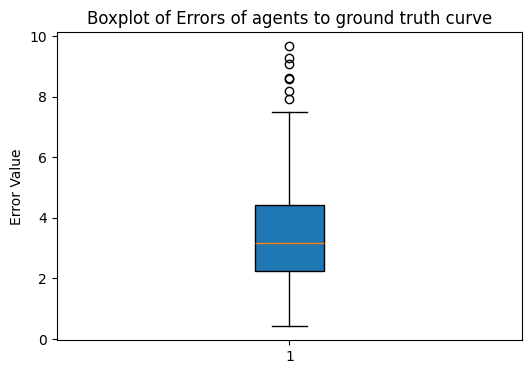

INFO:Logger:Average Validation Reward: -1.14


Average Total Reward: -1.14


INFO:Logger:Episode 61: Total Reward = 19.05 | Final Avg Distance 5.31 | Average error in mm [0.94 0.47 0.57 1.13 0.46 0.74] | Worst Error in mm [1.58 0.79 0.96 1.9  0.77 1.24] Avg Closest Point = 1.18 | Avg Furthest Point = 29.84 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 62: Total Reward = 21.37 | Final Avg Distance 3.00 | Average error in mm [0.57 0.83 0.38 0.19 0.28 0.18] | Worst Error in mm [0.96 1.41 0.63 0.32 0.47 0.31] Avg Closest Point = 0.57 | Avg Furthest Point = 24.57 | Finished Agents = tensor([0, 0, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 63: Total Reward = 8.79 | Final Avg Distance 12.82 | Average error in mm [1.01 7.62 5.6  2.11 3.15 2.06] | Worst Error in mm [ 1.7  12.85  9.45  3.57  5.32  3.47] Avg Closest Point = 1.90 | Avg Furthest Point = 25.40 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 64: Total Reward = 17.61 | Final

average error across all agents is 2.4441757202148438 mm


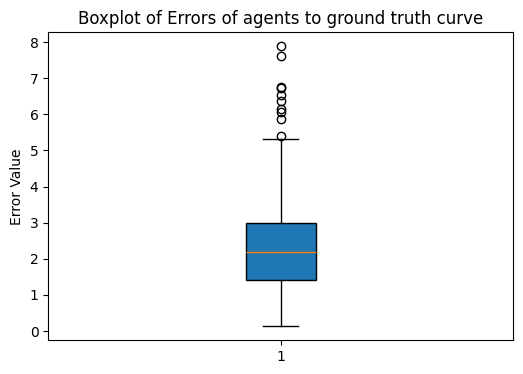

average error across all agents is 3.703674554824829 mm


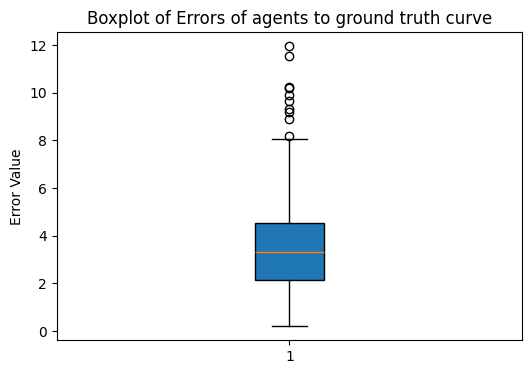

INFO:Logger:Average Validation Reward: -1.22


Average Total Reward: -1.22


INFO:Logger:Episode 71: Total Reward = 18.14 | Final Avg Distance 9.32 | Average error in mm [0.87 0.43 0.2  0.32 4.03 1.4 ] | Worst Error in mm [1.47 0.72 0.33 0.54 6.8  2.37] Avg Closest Point = 1.47 | Avg Furthest Point = 30.82 | Finished Agents = tensor([0, 1, 1, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 72: Total Reward = 24.29 | Final Avg Distance 3.17 | Average error in mm [0.09 0.59 0.62 0.5  0.6  0.41] | Worst Error in mm [0.15 0.99 1.05 0.84 1.02 0.69] Avg Closest Point = 0.67 | Avg Furthest Point = 28.67 | Finished Agents = tensor([1, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 73: Total Reward = 15.98 | Final Avg Distance 9.74 | Average error in mm [0.35 0.82 2.08 1.15 3.52 1.65] | Worst Error in mm [0.59 1.38 3.51 1.94 5.94 2.78] Avg Closest Point = 1.04 | Avg Furthest Point = 29.01 | Finished Agents = tensor([1, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 74: Total Reward = 21.81 | Final Avg D

average error across all agents is 2.350584030151367 mm


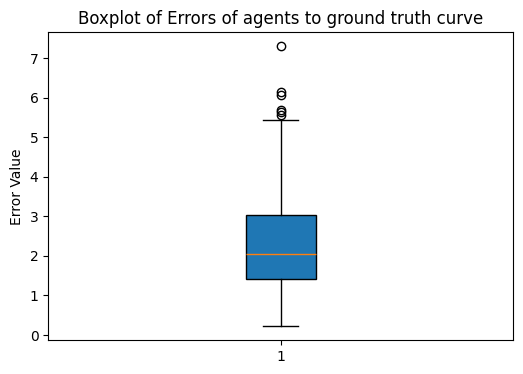

average error across all agents is 3.561854124069214 mm


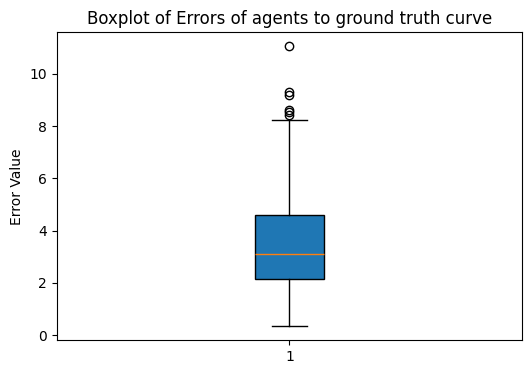

INFO:Logger:Average Validation Reward: -1.09


Average Total Reward: -1.09


INFO:Logger:Episode 81: Total Reward = 28.67 | Final Avg Distance 5.37 | Average error in mm [0.52 0.81 1.73 0.25 1.83 1.32] | Worst Error in mm [0.89 1.37 2.91 0.43 3.09 2.23] Avg Closest Point = 1.61 | Avg Furthest Point = 35.61 | Finished Agents = tensor([1, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 82: Total Reward = 30.86 | Final Avg Distance 3.19 | Average error in mm [1.02 0.54 0.39 0.8  0.52 0.27] | Worst Error in mm [1.71 0.91 0.66 1.34 0.89 0.46] Avg Closest Point = 0.67 | Avg Furthest Point = 35.65 | Finished Agents = tensor([0, 0, 1, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 83: Total Reward = -22.53 | Final Avg Distance 38.63 | Average error in mm [ 9.94  3.09 12.67 11.29  1.88 12.84] | Worst Error in mm [16.77  5.21 21.38 19.05  3.18 21.67] Avg Closest Point = 1.88 | Avg Furthest Point = 46.19 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 84: Total Reward = -0.10

average error across all agents is 2.004859447479248 mm


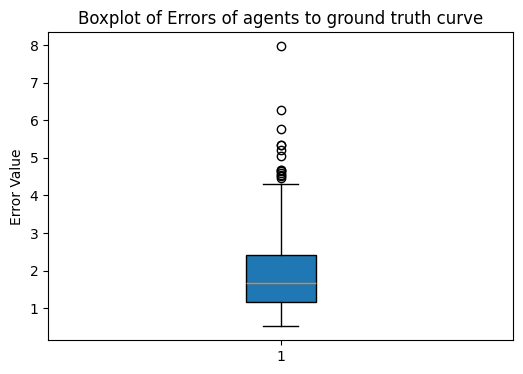

average error across all agents is 3.037975788116455 mm


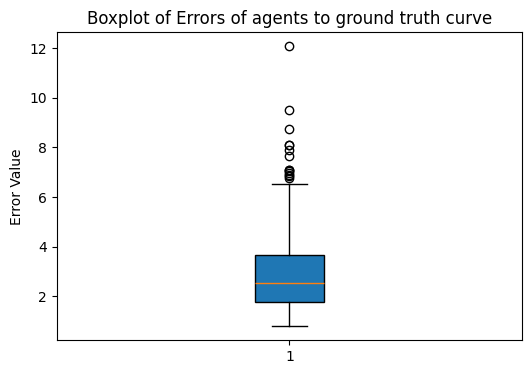

INFO:Logger:Average Validation Reward: 0.51
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: 0.51


INFO:Logger:Episode 91: Total Reward = 21.30 | Final Avg Distance 4.31 | Average error in mm [0.6  0.72 0.48 0.97 0.48 0.96] | Worst Error in mm [1.01 1.22 0.82 1.63 0.82 1.62] Avg Closest Point = 1.53 | Avg Furthest Point = 28.86 | Finished Agents = tensor([1, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 92: Total Reward = 23.36 | Final Avg Distance 2.26 | Average error in mm [0.48 0.6  0.36 0.36 0.36 0.12] | Worst Error in mm [0.81 1.02 0.6  0.6  0.6  0.2 ] Avg Closest Point = 0.86 | Avg Furthest Point = 27.67 | Finished Agents = tensor([1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 93: Total Reward = 23.41 | Final Avg Distance 3.37 | Average error in mm [0.62 0.27 0.77 0.56 0.09 0.56] | Worst Error in mm [1.05 0.45 1.3  0.95 0.15 0.95] Avg Closest Point = 1.00 | Avg Furthest Point = 30.65 | Finished Agents = tensor([0, 1, 0, 0, 1, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 94: Total Reward = 24.33 | Final Avg D

average error across all agents is 2.313169479370117 mm


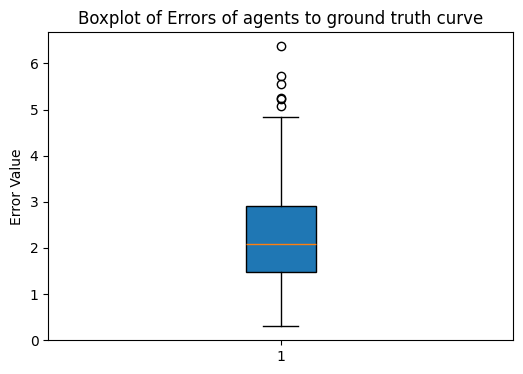

average error across all agents is 3.505160093307495 mm


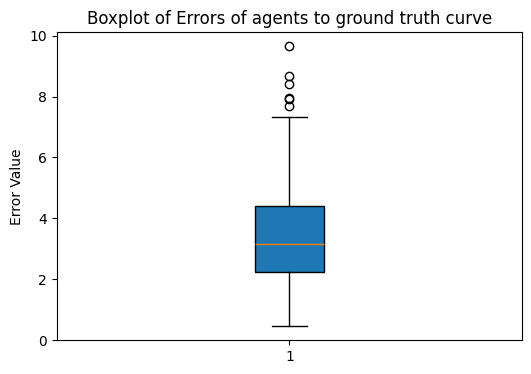

INFO:Logger:Average Validation Reward: -1.39


Average Total Reward: -1.39


/content/CardiacCTAnalysis/utils/logger.py:89: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["train_epochs"] = self.train_df
/content/CardiacCTAnalysis/utils/logger.py:90: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


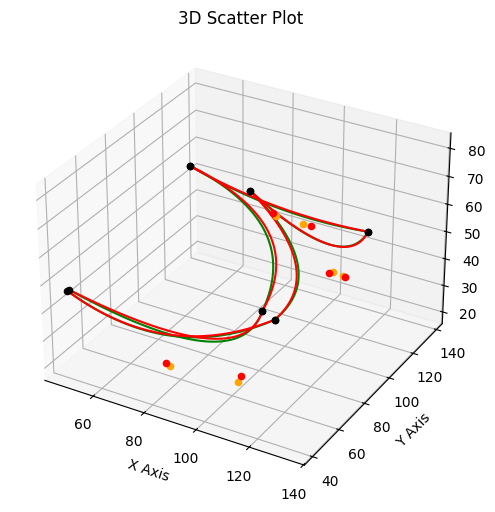

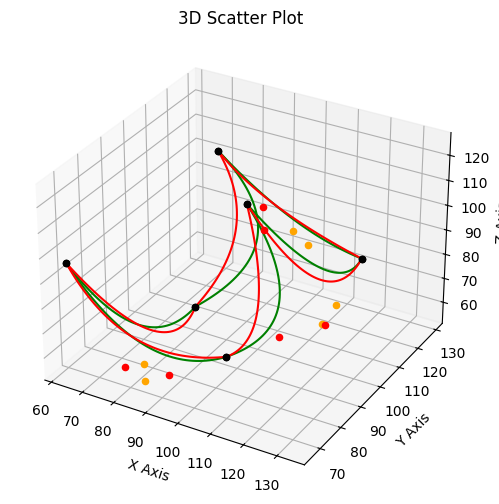

In [21]:
run_training(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = -1.56 | Final Avg Distance 13.79 | Average error in mm [0.9  1.6  1.07 1.99 4.92 4.98] | Worst Error in mm [1.36 2.43 1.62 3.01 7.45 7.55] Avg Closest Point = 10.33 | Avg Furthest Point = 15.96
INFO:Logger:Evaluation Episode 2: Total Reward = -1.09 | Final Avg Distance 15.06 | Average error in mm [1.94 1.63 3.47 0.61 1.   4.19] | Worst Error in mm [2.94 2.47 5.26 0.93 1.52 6.35] Avg Closest Point = 12.13 | Avg Furthest Point = 17.26
INFO:Logger:Evaluation Episode 3: Total Reward = -6.33 | Final Avg Distance 20.90 | Average error in mm [1.7  4.89 5.1  2.16 2.3  4.53] | Worst Error in mm [2.57 7.41 7.73 3.27 3.49 6.87] Avg Closest Point = 13.56 | Avg Furthest Point = 22.11
INFO:Logger:Evaluation Episode 4: Total Reward = -1.65 | Final Avg Distance 9.42 | Average error in mm [1.2  1.36 3.4  0.8  2.1  0.63] | Worst Error in mm [1.81 2.06 5.15 1.21 3.18 0.96] Avg Closest Point = 5.94 | Avg Furthest Point = 11.15
INFO:Logger:Evaluation Episode

average error across all agents is 2.4578278064727783 mm


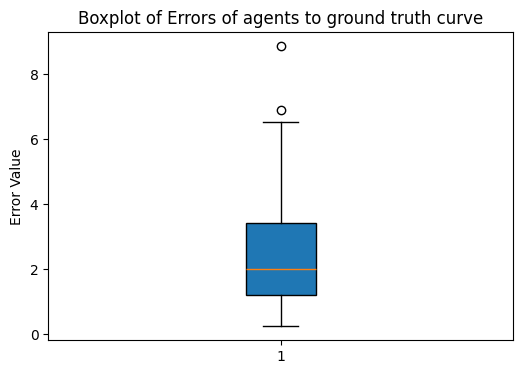

average error across all agents is 3.7243614196777344 mm


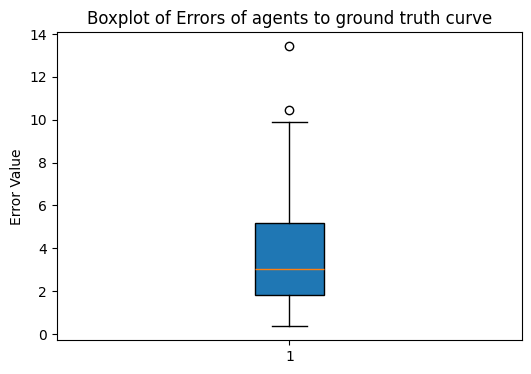

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


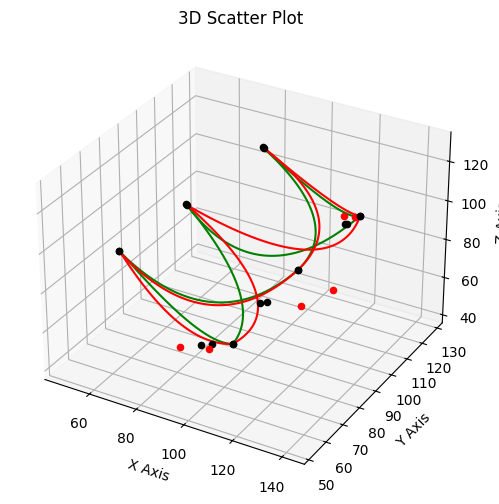

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = -0.55 | Final Avg Distance 16.71 | Average error in mm [1.19 2.29 6.68 0.71 3.41 4.  ] | Worst Error in mm [ 1.8   3.48 10.13  1.08  5.17  6.06] Avg Closest Point = 13.49 | Avg Furthest Point = 18.52
INFO:Logger:Evaluation Episode 2: Total Reward = 4.17 | Final Avg Distance 11.66 | Average error in mm [2.18 3.23 0.93 3.23 2.02 1.11] | Worst Error in mm [3.3  4.9  1.41 4.9  3.06 1.68] Avg Closest Point = 9.87 | Avg Furthest Point = 16.74
INFO:Logger:Evaluation Episode 3: Total Reward = -1.07 | Final Avg Distance 13.06 | Average error in mm [2.98 2.22 2.86 5.4  6.07 1.43] | Worst Error in mm [4.52 3.37 4.33 8.18 9.2  2.17] Avg Closest Point = 9.15 | Avg Furthest Point = 15.78
INFO:Logger:Evaluation Episode 4: Total Reward = -0.80 | Final Avg Distance 22.64 | Average error in mm [2.69 0.69 5.34 3.35 3.87 7.75] | Worst Error in mm [ 4.08  1.05  8.09  5.08  5.87 11.75] Avg Closest Point = 19.38 | Avg Furthest Point = 24.23
INFO:Logger:Evaluat

average error across all agents is 3.091773271560669 mm


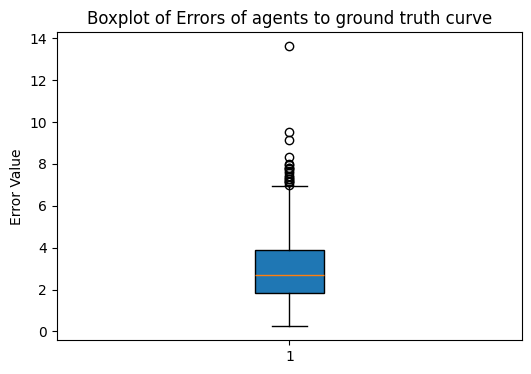

average error across all agents is 4.684983253479004 mm


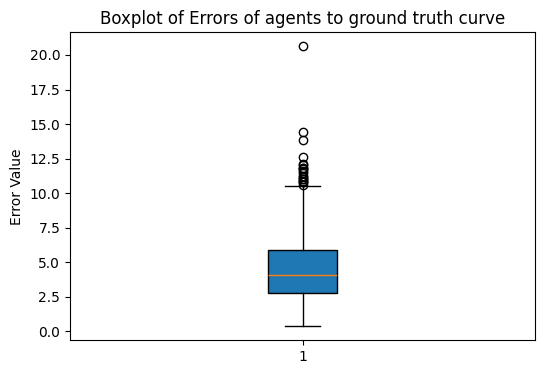

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


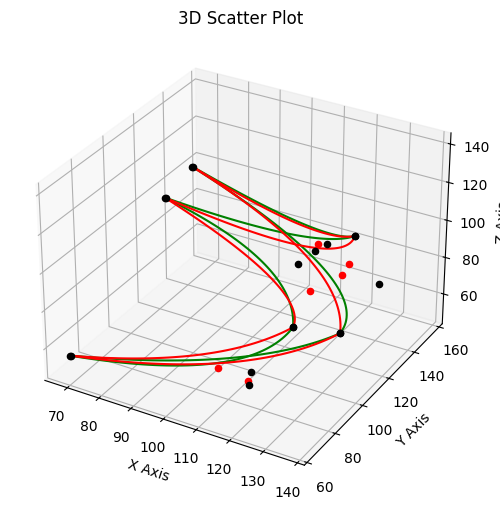

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

Experiment 6: CommNet - share pairwise

In [22]:
config.experiment = Experiment.SHARE_PAIRWISE

INFO:Logger:Episode 1: Total Reward = -23.23 | Final Avg Distance 35.24 | Average error in mm [13.94  9.09  4.64  9.04 16.28 10.47] | Worst Error in mm [23.52 15.35  7.83 15.25 27.48 17.67] Avg Closest Point = 3.11 | Avg Furthest Point = 40.81 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 2: Total Reward = -10.40 | Final Avg Distance 22.40 | Average error in mm [12.85  3.73  7.42  7.56  4.21  7.24] | Worst Error in mm [21.69  6.3  12.53 12.76  7.11 12.21] Avg Closest Point = 2.03 | Avg Furthest Point = 33.98 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 3: Total Reward = 15.34 | Final Avg Distance 17.92 | Average error in mm [3.45 1.66 0.55 4.53 1.69 3.87] | Worst Error in mm [5.83 2.8  0.93 7.65 2.86 6.52] Avg Closest Point = 6.98 | Avg Furthest Point = 40.01 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 4: Total Rew

average error across all agents is 2.328348159790039 mm


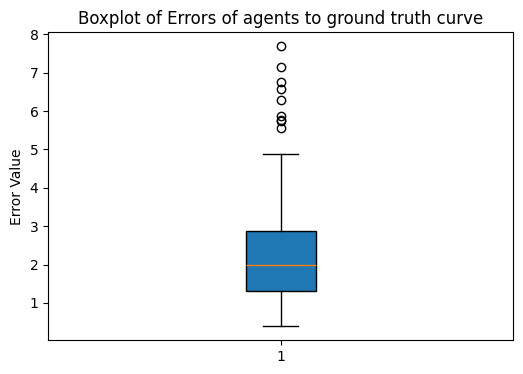

average error across all agents is 3.5281600952148438 mm


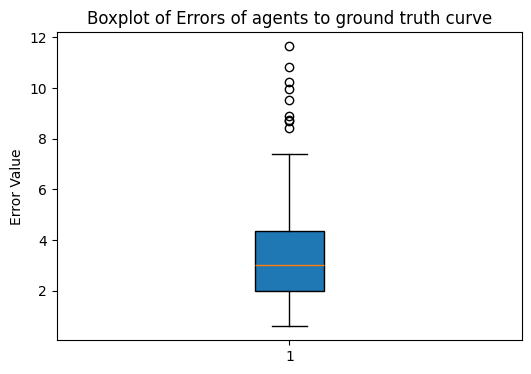

INFO:Logger:Average Validation Reward: -0.86
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -0.86


INFO:Logger:Episode 11: Total Reward = 20.05 | Final Avg Distance 9.81 | Average error in mm [1.06 1.49 0.97 2.75 2.15 2.81] | Worst Error in mm [1.79 2.51 1.64 4.64 3.63 4.74] Avg Closest Point = 2.78 | Avg Furthest Point = 34.60 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 12: Total Reward = 24.51 | Final Avg Distance 5.36 | Average error in mm [0.81 1.27 0.99 0.68 1.11 1.87] | Worst Error in mm [1.37 2.14 1.67 1.14 1.87 3.16] Avg Closest Point = 0.74 | Avg Furthest Point = 30.98 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 13: Total Reward = 18.06 | Final Avg Distance 9.79 | Average error in mm [1.92 0.62 2.48 2.57 0.56 0.92] | Worst Error in mm [3.25 1.05 4.19 4.34 0.95 1.55] Avg Closest Point = 1.68 | Avg Furthest Point = 31.85 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 14: Total Reward = 21.94 | Final Avg D

average error across all agents is 2.3458523750305176 mm


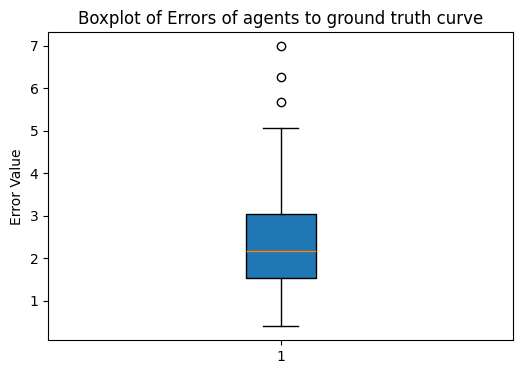

average error across all agents is 3.55468487739563 mm


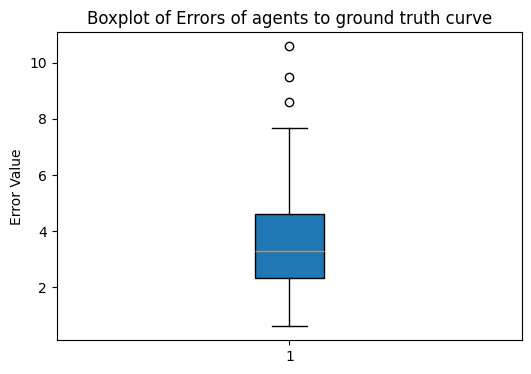

INFO:Logger:Average Validation Reward: -1.38


Average Total Reward: -1.38


INFO:Logger:Episode 21: Total Reward = 26.30 | Final Avg Distance 6.55 | Average error in mm [0.65 1.23 0.5  1.59 4.95 1.27] | Worst Error in mm [1.09 2.07 0.84 2.69 8.36 2.14] Avg Closest Point = 0.93 | Avg Furthest Point = 35.26 | Finished Agents = tensor([0, 0, 1, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 22: Total Reward = 30.81 | Final Avg Distance 2.04 | Average error in mm [0.5  0.86 0.24 0.39 0.47 0.13] | Worst Error in mm [0.84 1.45 0.4  0.65 0.8  0.22] Avg Closest Point = 0.33 | Avg Furthest Point = 35.03 | Finished Agents = tensor([1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 23: Total Reward = 23.91 | Final Avg Distance 6.95 | Average error in mm [0.67 1.59 1.19 1.58 0.67 1.13] | Worst Error in mm [1.12 2.68 2.   2.66 1.12 1.9 ] Avg Closest Point = 1.04 | Avg Furthest Point = 34.91 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 24: Total Reward = 26.03 | Final Avg D

average error across all agents is 2.536919593811035 mm


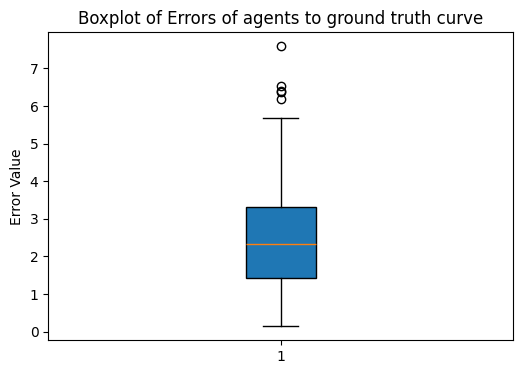

average error across all agents is 3.844209671020508 mm


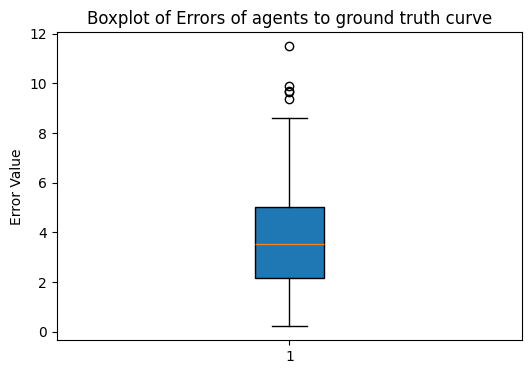

INFO:Logger:Average Validation Reward: -2.18


Average Total Reward: -2.18


INFO:Logger:Episode 31: Total Reward = 16.79 | Final Avg Distance 9.15 | Average error in mm [0.11 4.16 1.25 0.47 2.52 0.57] | Worst Error in mm [0.19 7.02 2.11 0.79 4.25 0.96] Avg Closest Point = 1.34 | Avg Furthest Point = 28.99 | Finished Agents = tensor([1, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 32: Total Reward = 21.07 | Final Avg Distance 4.88 | Average error in mm [0.82 1.14 0.57 0.7  0.93 0.57] | Worst Error in mm [1.39 1.92 0.97 1.18 1.57 0.97] Avg Closest Point = 0.50 | Avg Furthest Point = 26.94 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 33: Total Reward = -2.85 | Final Avg Distance 25.15 | Average error in mm [ 5.61  8.22  4.29  3.02  2.56 18.16] | Worst Error in mm [ 9.47 13.87  7.24  5.09  4.32 30.64] Avg Closest Point = 2.37 | Avg Furthest Point = 34.13 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 34: Total Reward = 19.31 

average error across all agents is 2.2218551635742188 mm


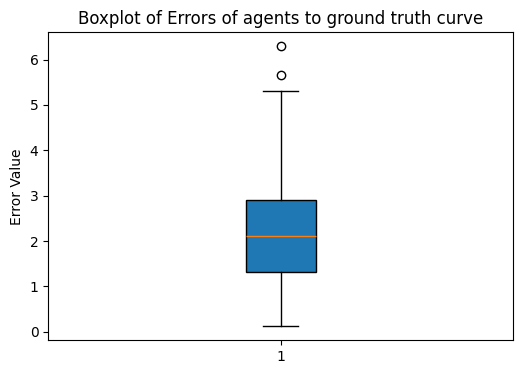

average error across all agents is 3.366790533065796 mm


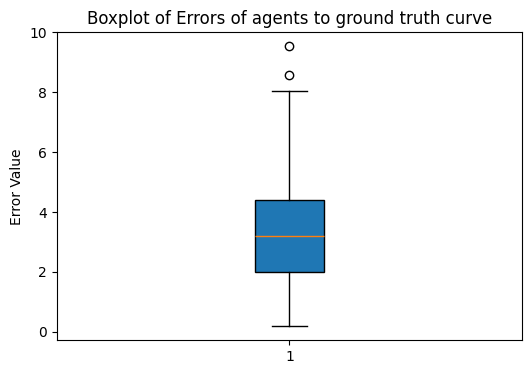

INFO:Logger:Average Validation Reward: -0.87


Average Total Reward: -0.87


INFO:Logger:Episode 41: Total Reward = 11.72 | Final Avg Distance 4.46 | Average error in mm [0.53 1.54 1.66 2.28 1.34 0.77] | Worst Error in mm [0.9  2.6  2.81 3.86 2.25 1.3 ] Avg Closest Point = 0.57 | Avg Furthest Point = 18.48 | Finished Agents = tensor([1, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 42: Total Reward = 13.60 | Final Avg Distance 2.59 | Average error in mm [0.92 0.77 0.53 0.77 0.59 0.36] | Worst Error in mm [1.55 1.3  0.9  1.3  1.   0.6 ] Avg Closest Point = 0.40 | Avg Furthest Point = 18.06 | Finished Agents = tensor([1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 43: Total Reward = 21.08 | Final Avg Distance 6.12 | Average error in mm [0.6  1.03 1.56 0.54 1.35 0.81] | Worst Error in mm [1.01 1.73 2.64 0.91 2.27 1.37] Avg Closest Point = 1.36 | Avg Furthest Point = 31.24 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 44: Total Reward = 23.91 | Final Avg D

average error across all agents is 2.3759922981262207 mm


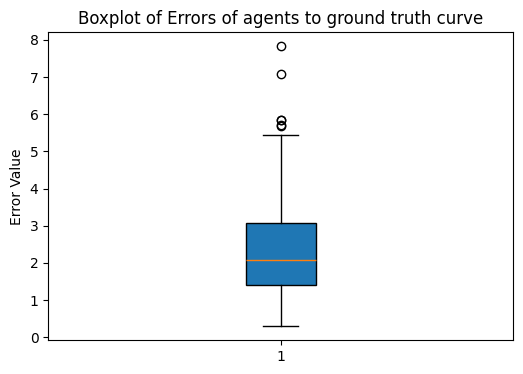

average error across all agents is 3.600355625152588 mm


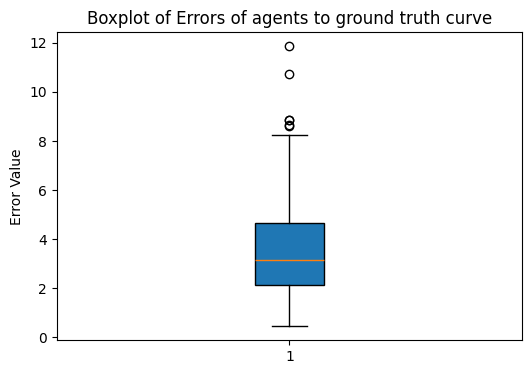

INFO:Logger:Average Validation Reward: -1.17


Average Total Reward: -1.17


INFO:Logger:Episode 51: Total Reward = 24.16 | Final Avg Distance 6.48 | Average error in mm [2.29 0.82 0.35 1.26 1.73 0.35] | Worst Error in mm [3.87 1.38 0.58 2.12 2.92 0.58] Avg Closest Point = 2.23 | Avg Furthest Point = 33.47 | Finished Agents = tensor([0, 0, 1, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 52: Total Reward = 27.12 | Final Avg Distance 3.51 | Average error in mm [0.69 0.34 0.35 0.81 1.03 0.12] | Worst Error in mm [1.16 0.57 0.59 1.37 1.74 0.2 ] Avg Closest Point = 0.33 | Avg Furthest Point = 32.28 | Finished Agents = tensor([0, 1, 1, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 53: Total Reward = 22.47 | Final Avg Distance 5.15 | Average error in mm [0.44 0.58 0.6  0.81 1.09 0.76] | Worst Error in mm [0.75 0.98 1.   1.37 1.84 1.28] Avg Closest Point = 1.18 | Avg Furthest Point = 29.82 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 54: Total Reward = 21.58 | Final Avg D

average error across all agents is 2.362281084060669 mm


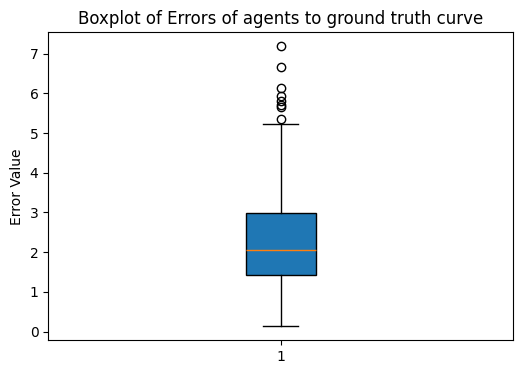

average error across all agents is 3.5795791149139404 mm


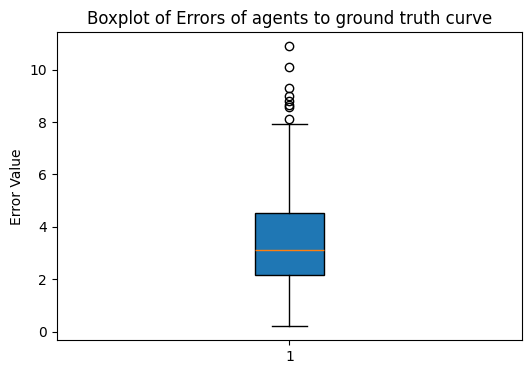

INFO:Logger:Average Validation Reward: -1.17


Average Total Reward: -1.17


INFO:Logger:Episode 61: Total Reward = 20.53 | Final Avg Distance 9.49 | Average error in mm [0.94 1.77 0.8  5.32 1.36 0.93] | Worst Error in mm [1.59 2.99 1.34 8.97 2.29 1.57] Avg Closest Point = 3.15 | Avg Furthest Point = 32.94 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 62: Total Reward = 26.95 | Final Avg Distance 3.07 | Average error in mm [0.71 0.44 0.55 1.08 0.53 0.13] | Worst Error in mm [1.2  0.75 0.92 1.82 0.89 0.22] Avg Closest Point = 0.80 | Avg Furthest Point = 31.70 | Finished Agents = tensor([0, 1, 1, 0, 0, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 63: Total Reward = 4.32 | Final Avg Distance 23.06 | Average error in mm [ 1.97  1.57  2.96  0.82 12.92  3.22] | Worst Error in mm [ 3.32  2.65  5.    1.38 21.81  5.43] Avg Closest Point = 1.55 | Avg Furthest Point = 35.80 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 64: Total Reward = 22.23 |

average error across all agents is 2.4568984508514404 mm


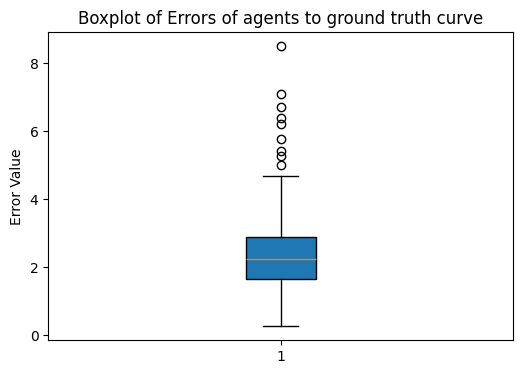

average error across all agents is 3.7229528427124023 mm


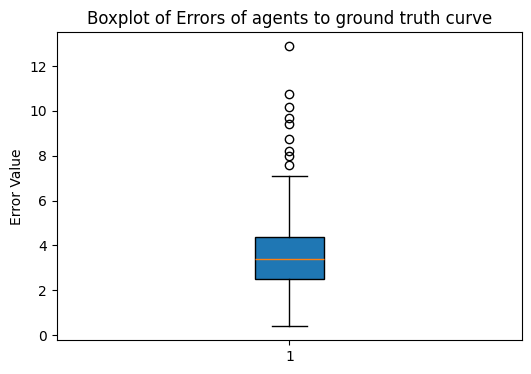

INFO:Logger:Average Validation Reward: -1.38


Average Total Reward: -1.38


INFO:Logger:Episode 71: Total Reward = 20.34 | Final Avg Distance 5.44 | Average error in mm [1.76 1.04 0.62 1.42 1.56 1.83] | Worst Error in mm [2.98 1.75 1.05 2.39 2.63 3.09] Avg Closest Point = 2.09 | Avg Furthest Point = 35.00 | Finished Agents = tensor([0, 0, 1, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 72: Total Reward = 23.11 | Final Avg Distance 2.66 | Average error in mm [0.93 0.73 0.93 0.76 0.52 0.76] | Worst Error in mm [1.58 1.23 1.58 1.28 0.88 1.28] Avg Closest Point = 0.97 | Avg Furthest Point = 27.35 | Finished Agents = tensor([1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 73: Total Reward = 19.48 | Final Avg Distance 2.13 | Average error in mm [0.24 0.38 0.81 0.62 0.77 0.67] | Worst Error in mm [0.4  0.65 1.37 1.05 1.3  1.12] Avg Closest Point = 0.87 | Avg Furthest Point = 24.14 | Finished Agents = tensor([1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 74: Total Reward = 19.80 | Final Avg D

average error across all agents is 2.243955135345459 mm


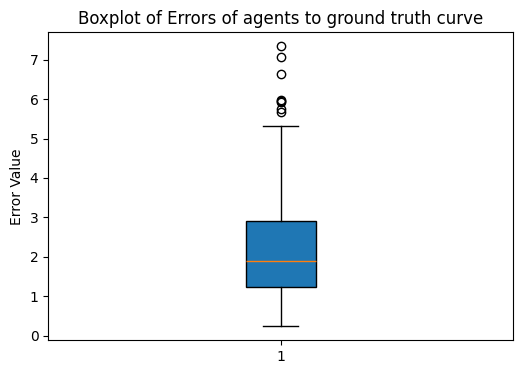

average error across all agents is 3.4002790451049805 mm


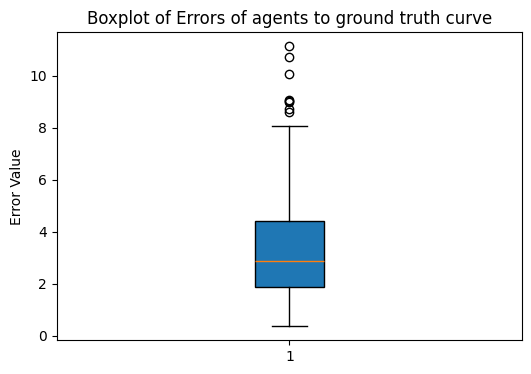

INFO:Logger:Average Validation Reward: -0.11
INFO:Logger:New best validation reward! Saving model.


Average Total Reward: -0.11


INFO:Logger:Episode 81: Total Reward = 7.01 | Final Avg Distance 3.38 | Average error in mm [0.61 0.91 1.3  1.8  0.82 1.32] | Worst Error in mm [1.04 1.54 2.19 3.04 1.38 2.23] Avg Closest Point = 0.78 | Avg Furthest Point = 19.34 | Finished Agents = tensor([1, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 82: Total Reward = 8.01 | Final Avg Distance 2.38 | Average error in mm [0.61 1.   0.61 1.21 0.   0.91] | Worst Error in mm [1.04 1.69 1.04 2.04 0.   1.54] Avg Closest Point = 1.17 | Avg Furthest Point = 11.71 | Finished Agents = tensor([1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 83: Total Reward = 20.60 | Final Avg Distance 3.89 | Average error in mm [1.28 0.83 0.32 0.73 0.42 0.3 ] | Worst Error in mm [2.17 1.4  0.54 1.23 0.71 0.51] Avg Closest Point = 0.80 | Avg Furthest Point = 26.81 | Finished Agents = tensor([0, 0, 1, 0, 1, 1], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 84: Total Reward = 22.47 | Final Avg Dis

average error across all agents is 2.2580947875976562 mm


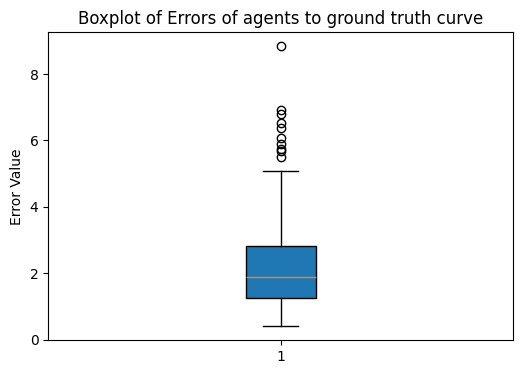

average error across all agents is 3.4217050075531006 mm


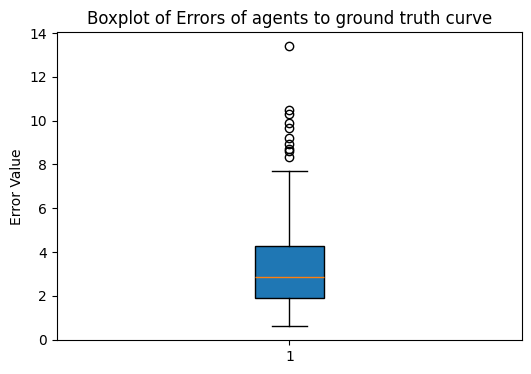

INFO:Logger:Average Validation Reward: -0.28


Average Total Reward: -0.28


INFO:Logger:Episode 91: Total Reward = 22.64 | Final Avg Distance 7.04 | Average error in mm [1.9  1.08 1.28 0.87 0.53 0.66] | Worst Error in mm [3.2  1.82 2.16 1.47 0.89 1.11] Avg Closest Point = 1.97 | Avg Furthest Point = 37.61 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 92: Total Reward = 18.61 | Final Avg Distance 11.07 | Average error in mm [1.44 0.66 0.76 1.8  5.25 1.54] | Worst Error in mm [2.42 1.11 1.29 3.04 8.87 2.6 ] Avg Closest Point = 2.74 | Avg Furthest Point = 45.35 | Finished Agents = tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 93: Total Reward = 21.78 | Final Avg Distance 3.99 | Average error in mm [0.55 0.45 1.01 0.67 0.88 0.54] | Worst Error in mm [0.93 0.77 1.7  1.13 1.49 0.92] Avg Closest Point = 1.14 | Avg Furthest Point = 27.08 | Finished Agents = tensor([1, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
INFO:Logger:Episode 94: Total Reward = 23.75 | Final Avg 

average error across all agents is 2.1795451641082764 mm


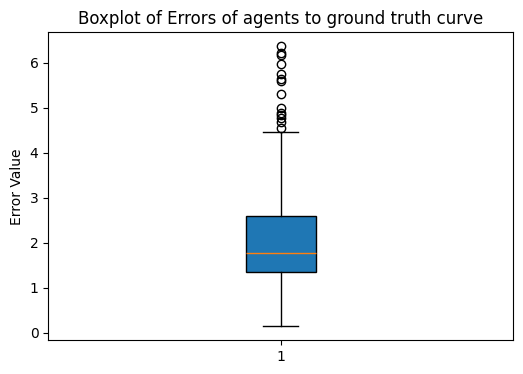

average error across all agents is 3.302677869796753 mm


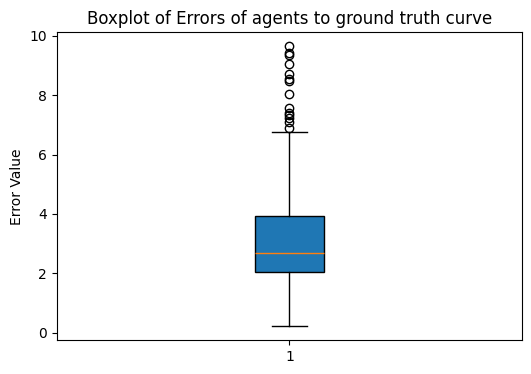

INFO:Logger:Average Validation Reward: -0.14


Average Total Reward: -0.14


/content/CardiacCTAnalysis/utils/logger.py:89: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["train_epochs"] = self.train_df
/content/CardiacCTAnalysis/utils/logger.py:90: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


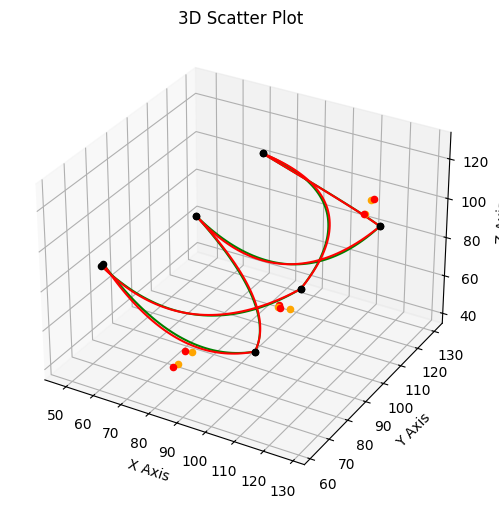

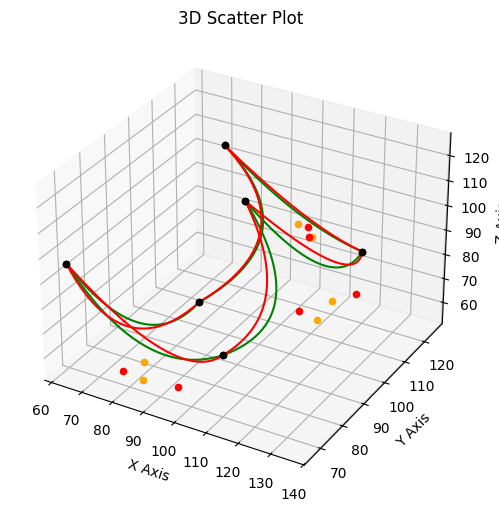

In [23]:
run_training(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = -4.09 | Final Avg Distance 16.32 | Average error in mm [0.46 1.59 1.89 3.81 4.08 4.37] | Worst Error in mm [0.7  2.41 2.87 5.78 6.19 6.63] Avg Closest Point = 11.01 | Avg Furthest Point = 18.36
INFO:Logger:Evaluation Episode 2: Total Reward = 0.71 | Final Avg Distance 13.26 | Average error in mm [1.1  2.05 2.66 0.2  1.82 4.14] | Worst Error in mm [1.67 3.1  4.03 0.31 2.76 6.27] Avg Closest Point = 11.13 | Avg Furthest Point = 16.06
INFO:Logger:Evaluation Episode 3: Total Reward = -0.40 | Final Avg Distance 14.96 | Average error in mm [1.86 6.13 2.9  1.37 3.63 1.74] | Worst Error in mm [2.82 9.29 4.39 2.08 5.5  2.63] Avg Closest Point = 11.97 | Avg Furthest Point = 17.09
INFO:Logger:Evaluation Episode 4: Total Reward = -1.66 | Final Avg Distance 9.43 | Average error in mm [3.36 1.09 0.77 1.66 2.03 0.96] | Worst Error in mm [5.09 1.66 1.16 2.52 3.08 1.45] Avg Closest Point = 5.29 | Avg Furthest Point = 10.12
INFO:Logger:Evaluation Episode 

average error across all agents is 2.229482889175415 mm


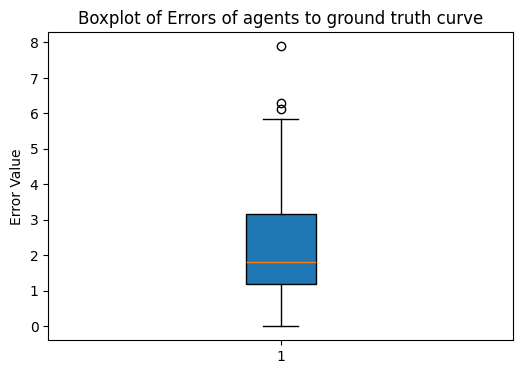

average error across all agents is 3.3783493041992188 mm


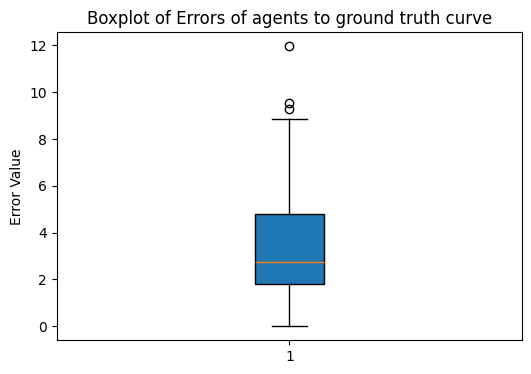

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


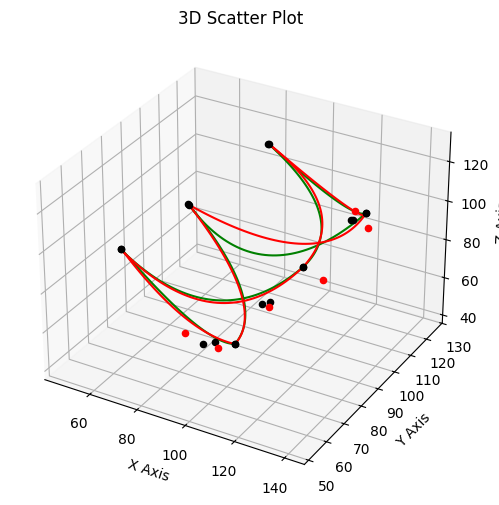

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = 5.92 | Final Avg Distance 10.24 | Average error in mm [0.71 1.62 2.65 1.46 1.78 3.09] | Worst Error in mm [1.08 2.46 4.01 2.22 2.7  4.68] Avg Closest Point = 9.27 | Avg Furthest Point = 16.33
INFO:Logger:Evaluation Episode 2: Total Reward = 3.09 | Final Avg Distance 12.73 | Average error in mm [2.18 4.85 1.83 1.22 1.57 1.27] | Worst Error in mm [3.3  7.35 2.77 1.84 2.37 1.93] Avg Closest Point = 10.39 | Avg Furthest Point = 16.23
INFO:Logger:Evaluation Episode 3: Total Reward = -0.86 | Final Avg Distance 12.85 | Average error in mm [4.4  3.37 2.94 3.33 1.27 3.21] | Worst Error in mm [6.67 5.11 4.46 5.05 1.93 4.86] Avg Closest Point = 9.49 | Avg Furthest Point = 15.33
INFO:Logger:Evaluation Episode 4: Total Reward = -1.88 | Final Avg Distance 23.72 | Average error in mm [1.05 1.39 5.69 4.47 4.48 8.24] | Worst Error in mm [ 1.59  2.1   8.62  6.77  6.79 12.49] Avg Closest Point = 20.18 | Avg Furthest Point = 24.94
INFO:Logger:Evaluation Epi

average error across all agents is 2.739433526992798 mm


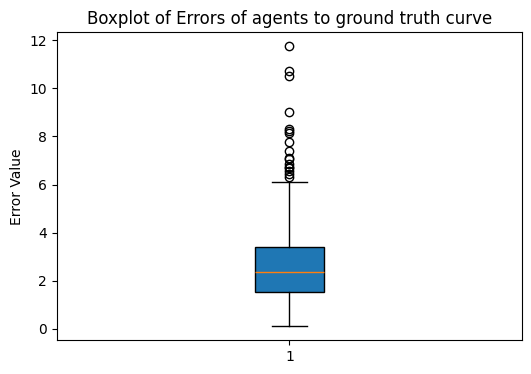

average error across all agents is 4.15108060836792 mm


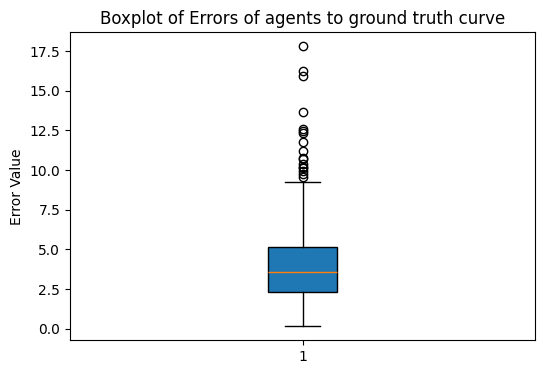

/content/CardiacCTAnalysis/utils/logger.py:69: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['avg_err_in_mm', 'worst_err_in_mm'], dtype='object')]

  store["val_epochs"] = self.val_df


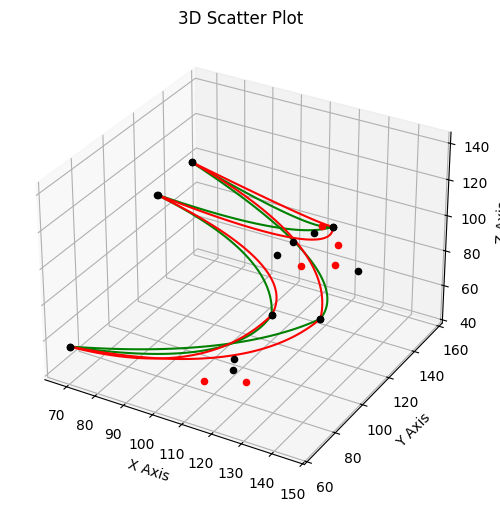

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

DDQN

In [1]:
config = ExperimentConfig(model_type="Network3D",
                          rl_framework="DDQN",
                          max_steps=500,
                          image_interval=2,
                          episodes=100,
                          agents=6,
                          evaluation_steps=15,
                          evaluation_interval=10,
                          decay=150, # EPSILON = MIN_EPS - (MAX_EPS - MIN_EPS) * e^(-1 * current_step / decay)
                          attention=False,
                          experiment=Experiment.WORK_ALONE,
                          n_sample_points=5,
                          add_noise=True
                          )

NameError: name 'ExperimentConfig' is not defined

In [29]:
run_training(config, logger=logger, dataLoader=dataLoader)

KeyboardInterrupt: 

In [28]:
run_test(config, logger=logger, dataLoader=dataLoader)

SyntaxError: invalid syntax (<ipython-input-28-dd08ac3107f9>, line 1)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

In [ ]:
config.experiment = Experiment.SHARE_POSITIONS

In [ ]:
run_training(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

In [ ]:
config.experiment = Experiment.SHARE_PAIRWISE

In [ ]:
run_training(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

In [ ]:
config.experiment = Experiment.WORK_ALONE
config.model_type = "CommNet"

In [ ]:
run_training(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

In [ ]:
config.experiment = Experiment.SHARE_POSITIONS

In [ ]:
run_training(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)

In [ ]:
config.experiment = Experiment.SHARE_PAIRWISE

In [ ]:
run_training(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)